In [1]:
import os
import torch
import pwcca
import timeit
import random
import librosa
# import opensmile
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import soundfile as sf
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, normalize
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
import sys
sys.path.append('/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/phdwork/Layerwise')

In [3]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

durs = []
lens = []

for file in os.listdir('.'):
    dur = librosa.get_duration(filename=file)
    audioinput, sr = librosa.load(file, sr=16000)
    durs.append(dur)
    lens.append(len(audioinput))

print(max(durs), max(lens))

print(np.mean(np.array(durs)) + np.std(np.array(durs))) # ave duration + std deviation
print(np.mean(np.array(lens)) + np.std(np.array(lens))) # ave duration + std deviation

8.97825 143652
3.806839123563467
60909.42597701548


In [3]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A = np.array([])
hct_E = np.array([])
hct_F = np.array([])
hct_L = np.array([])
hct_N = np.array([])
hct_T = np.array([])
hct_W = np.array([])

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length
    
#     utterance features
#     utter = []
#     kur = kurtosis(audioinput)
#     ske = skew(audioinput)
#     ma = np.amax(np.array(audioinput), axis=0)
#     mi = np.amin(np.array(audioinput), axis=0)
#     ave = np.mean(np.array(audioinput), axis=0)
#     var = np.var(np.array(audioinput), axis=0)
    
#     for i in (kur, ske, ma, mi, ave, var):
#         utter.append(i)
    
#     spectral features
    mfcc = librosa.feature.mfcc(y=audioinput, sr=sr, n_fft=800, hop_length=400, n_mfcc=40)
    mfcc_frame = np.mean(mfcc.T, axis=0) #frame level
#     mfcc_phoneme = []
#     for i in range(0,len(mfcc_frame)-3,2):
#         mfcc_phoneme.append((mfcc_frame[i]+mfcc_frame[i+1]+mfcc_frame[i+2])/3) #phoneme level
#     mfcc_word=[]
#     for i in range(0, len(mfcc_phoneme)-5,4):
#         mfcc_word.append((mfcc_phoneme[i]+mfcc_phoneme[i+1]+mfcc_phoneme[i+4])/5) #word level
#     mfcc_utter=[]
#     mfcc_utter = np.mean(mfcc_word) #utterance level

#     for i in (kur, ske, ma, mi, ave, var):
#         mfcc_utter = np.append(mfcc_utter, i)

#     mel = librosa.feature.melspectrogram(y=audioinput, sr=sr, n_fft=800, hop_length=400)
#     mel_del = librosa.feature.delta(mel, order=1)
#     mel_del2 = librosa.feature.delta(mel, order=2)
#     mels = np.vstack((mel, mel_del, mel_del2))
#     mels_frame = np.mean(mels.T, axis=0)
#     mels_phoneme = []
#     for i in range(0,len(mels_frame)-3,2):
#         mels_phoneme.append((mels_frame[i]+mels_frame[i+1]+mels_frame[i+2])/3) #phoneme level
#     mels_word=[]
#     for i in range(0, len(mels_phoneme)-5,4):
#         mels_word.append((mels_phoneme[i]+mels_phoneme[i+1]+mels_phoneme[i+4])/5) #word level
#     mels_utter=[]
#     for i in range(0, len(mels_word)-10,9):
#         mels_utter.append((mels_word[i]+mels_word[i+1]+mels_word[i+9])/5) #utterance level
            
#     prosodic features
#     eng_frame = librosa.feature.rms(y=audioinput, frame_length=800, hop_length=400)
#     f0_frame = librosa.yin(audioinput, frame_length=800, hop_length=400, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

#     eng_phoneme = []
#     for i in range(0,len(eng_frame)-3,2):
#         eng_phoneme.append((eng_frame[i]+eng_frame[i+1]+eng_frame[i+2])/3) #phoneme level
#     eng_word=[]
#     for i in range(0, len(eng_phoneme)-5,4):
#         eng_word.append((eng_phoneme[i]+eng_phoneme[i+1]+eng_phoneme[i+4])/5) #word level
#     eng_utter=[]
#     for i in range(0, len(eng_word)-10,9):
#         eng_utter.append((eng_word[i]+eng_word[i+1]+eng_word[i+9])/5) #utterance level
        
#     f0_phoneme = []
#     for i in range(0,len(f0_frame)-3,2):
#         f0_phoneme.append((f0_frame[i]+f0_frame[i+1]+f0_frame[i+2])/3) #phoneme level
#     f0_word=[]
#     for i in range(0, len(f0_phoneme)-5,4):
#         f0_word.append((f0_phoneme[i]+f0_phoneme[i+1]+f0_phoneme[i+4])/5) #word level
#     f0_utter=[]
#     for i in range(0, len(f0_word)-10,9):
#         f0_utter.append((f0_word[i]+f0_word[i+1]+f0_word[i+9])/5) #utterance level
    
#     kur_e = kurtosis(eng_frame)
#     ske_e = skew(eng_frame)
#     max_e = np.amax(np.array(eng_frame), axis=0)
#     min_e = np.amin(np.array(eng_frame), axis=0)
#     ave_e = np.mean(np.array(eng_frame), axis=0)
#     rag_e = max_e-min_e
    
#     kur_f = kurtosis(f0_frame)
#     ske_f = skew(f0_frame)
#     max_f = np.amax(np.array(f0_frame), axis=0)
#     min_f = np.amin(np.array(f0_frame), axis=0)
#     ave_f = np.mean(np.array(f0_frame), axis=0)
#     rag_f = max_f-min_f

#     for i in (kur_e, ske_e, max_e, min_e, ave_e, rag_e):
#         eng_utter.append(i)
#     for i in (kur_f, ske_f, max_f, min_f, ave_f, rag_f):
#         f0_utter.append(i)
    
    hct = np.array(mfcc_frame)
    
    #separate accroindg to emotions
    if file[5] == 'A':
        hct_A = np.append(hct_A, hct)
        hct_A = np.reshape(hct_A, (-1, hct.size))
    elif file[5] == 'E':
        hct_E = np.append(hct_E, hct)
        hct_E = np.reshape(hct_E, (-1, hct.size)) 
    elif file[5] == 'F':
        hct_F = np.append(hct_F, hct)
        hct_F = np.reshape(hct_F, (-1, hct.size))
    elif file[5] == 'L':
        hct_L = np.append(hct_L, hct)
        hct_L = np.reshape(hct_L, (-1, hct.size))
    elif file[5] == 'N':
        hct_N = np.append(hct_N, hct)
        hct_N = np.reshape(hct_N, (-1, hct.size))
    elif file[5] == 'T':
        hct_T = np.append(hct_T, hct)
        hct_T = np.reshape(hct_T, (-1, hct.size))
    elif file[5] == 'W':
        hct_W = np.append(hct_W, hct)
        hct_W = np.reshape(hct_W, (-1, hct.size))

print('finished')

finished


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

In [3]:
labels = [0] * 69 + [1] * 46 + [2] * 71 + [3] * 81 + [4] * 79 + [5] * 62 + [6] * 127

In [6]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A = np.array([])
hct_E = np.array([])
hct_F = np.array([])
hct_L = np.array([])
hct_N = np.array([])
hct_T = np.array([])
hct_W = np.array([])

torch.cuda.empty_cache()

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length    
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
    w2v_feats_layer = w2v_feats[0].detach()[0].mean(dim=0)
        
    hct = np.array(w2v_feats_layer.cpu())
    torch.cuda.empty_cache()
    
    #separate accroindg to emotions
    if file[5] == 'A':
        hct_A = np.append(hct_A, hct)
        hct_A = np.reshape(hct_A, (-1, hct.size))
    elif file[5] == 'E':
        hct_E = np.append(hct_E, hct)
        hct_E = np.reshape(hct_E, (-1, hct.size)) 
    elif file[5] == 'F':
        hct_F = np.append(hct_F, hct)
        hct_F = np.reshape(hct_F, (-1, hct.size))
    elif file[5] == 'L':
        hct_L = np.append(hct_L, hct)
        hct_L = np.reshape(hct_L, (-1, hct.size))
    elif file[5] == 'N':
        hct_N = np.append(hct_N, hct)
        hct_N = np.reshape(hct_N, (-1, hct.size))
    elif file[5] == 'T':
        hct_T = np.append(hct_T, hct)
        hct_T = np.reshape(hct_T, (-1, hct.size))
    elif file[5] == 'W':
        hct_W = np.append(hct_W, hct)
        hct_W = np.reshape(hct_W, (-1, hct.size))
        
hct_feats = np.vstack((hct_A, hct_E, hct_F, hct_L, hct_N, hct_T, hct_W))
print('finished')

finished


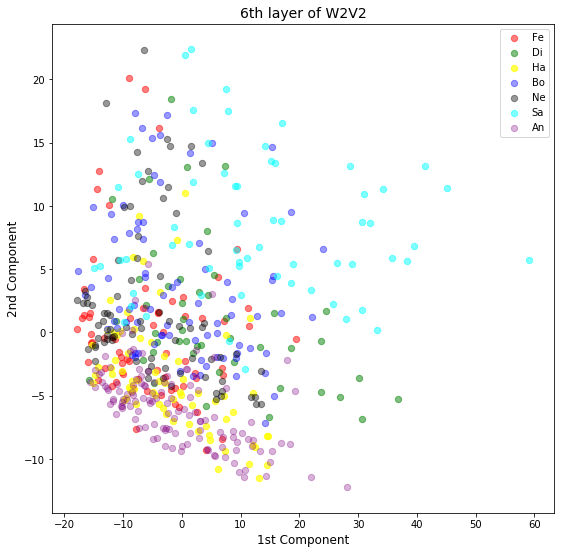

In [7]:
#plot 2d distribution

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

X = hct_feats
Y = labels

# scaler = StandardScaler()
# scaler.fit(X)
# X_scaled = scaler.transform(X)

pca = PCA(n_components=2)
pca.fit(X)
X_new = pca.transform(X)

# lda = LDA(n_components=2)
# lda.fit(X_scaled, Y)
# X_new = lda.transform(X_scaled)

ex_variance=np.var(X_new,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_new[:,0]
Yax = X_new[:,1]

cdict = {0:'red',1:'green',2:'yellow',3:'blue',4:'black',5:'cyan',6:'purple'}
labl = {0:'Fe',1:'Di',2:'Ha',3:'Bo',4:'Ne',5:'Sa',6:'An'}
marker = {0:'o',1:'o',2:'o',3:'o',4:'o',5:'o',6:'o'}
alpha = {0:.5,1:.5,2:.7,3:.4,4:.4,5:.5,6:.3}

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

fig.patch.set_facecolor('white')
for l in np.unique(Y):
    ix=np.where(Y==l)
    ax.scatter(Xax[ix], Yax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])

ax.set_xlabel('1st Component', fontsize=12)
ax.set_ylabel('2nd Component', fontsize=12)
ax.set_title('6th layer of W2V2', fontsize=14)

ax.legend()
plt.show()

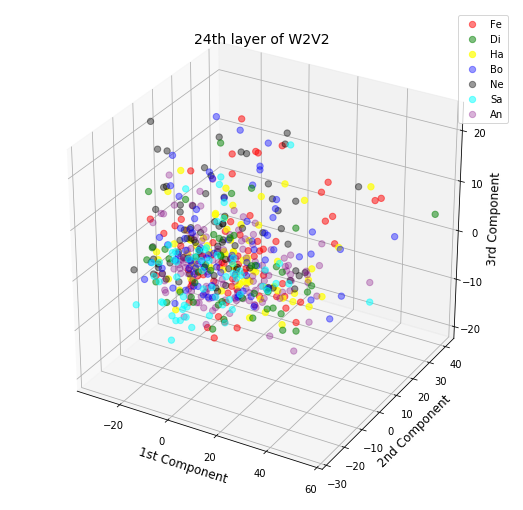

In [7]:
#plot 3d distribution

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

X = hct_feats
Y = labels

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled) 
X_new = pca.transform(X_scaled)

# lda = LDA(n_components=3)
# lda.fit(X_scaled, Y)
# X_new = lda.transform(X_scaled)

ex_variance=np.var(X_new,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_new[:,0]
Yax = X_new[:,1]
Zax = X_new[:,2]

cdict = {0:'red',1:'green',2:'yellow',3:'blue',4:'black',5:'cyan',6:'purple'}
labl = {0:'Fe',1:'Di',2:'Ha',3:'Bo',4:'Ne',5:'Sa',6:'An'}
marker = {0:'o',1:'o',2:'o',3:'o',4:'o',5:'o',6:'o'}
alpha = {0:.5,1:.5,2:.7,3:.4,4:.4,5:.5,6:.3}

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(Y):
    ix=np.where(Y==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])

ax.set_xlabel("1st Component", fontsize=12)
ax.set_ylabel("2nd Component", fontsize=12)
ax.set_zlabel("3rd Component", fontsize=12)
ax.set_title('24th layer of W2V2', fontsize=14)

ax.legend()
plt.show()

In [121]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader

A = X_scaled[0:69]
yA = [1]*69
E = X_scaled[69:115]
yE = [1]*46
F = X_scaled[115:186]
yF = [1]*71
L = X_scaled[186:267]
yL = [1]*81
N = X_scaled[267:346]
yN = [1]*79
T = X_scaled[346:408]
yT = [1]*62
W = X_scaled[408:535]
yW = [1]*127

A_train = A[:int(69*0.7)]
A_test = A[int(69*0.7):]
E_train = E[:int(46*0.7)]
E_test = E[int(46*0.7):]
F_train = F[:int(71*0.7)]
F_test = F[int(71*0.7):]
L_train = L[:int(81*0.7)]
L_test = L[int(81*0.7):]
N_train = N[:int(79*0.7)]
N_test = N[int(79*0.7):]
T_train = T[:int(62*0.7)]
T_test = T[int(62*0.7):]
W_train = W[:int(127*0.7)]
W_test = W[int(127*0.7):]

In [122]:
#Quantitative analysis

from sklearn.metrics import precision_recall_fscore_support

#A vs other
x_train = np.vstack((A_train,E_train,F_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((A_test,E_test,F_test,L_test,N_test,T_test,W_test))
y_train = yA[:int(69*0.7)] + [0]*(len(x_train)-len(yA[:int(69*0.7)]))
y_test = yA[int(69*0.7):] + [0]*(len(x_test)-len(yA[int(69*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Fear:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#E vs other
x_train = np.vstack((E_train,A_train,F_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((E_test,A_test,F_test,L_test,N_test,T_test,W_test))
y_train = yE[:int(46*0.7)] + [0]*(len(x_train)-len(yE[:int(46*0.7)]))
y_test = yE[int(46*0.7):] + [0]*(len(x_test)-len(yE[int(46*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Disg:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#F vs other
x_train = np.vstack((F_train,A_train,E_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((F_test,A_test,E_test,L_test,N_test,T_test,W_test))
y_train = yF[:int(71*0.7)] + [0]*(len(x_train)-len(yF[:int(71*0.7)]))
y_test = yF[int(71*0.7):] + [0]*(len(x_test)-len(yF[int(71*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Happ:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#L vs other
x_train = np.vstack((L_train,A_train,E_train,F_train,N_train,T_train,W_train))
x_test = np.vstack((L_test,A_test,E_test,F_test,N_test,T_test,W_test))
y_train = yL[:int(81*0.7)] + [0]*(len(x_train)-len(yL[:int(81*0.7)]))
y_test = yL[int(81*0.7):] + [0]*(len(x_test)-len(yL[int(81*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Bord:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#N vs other
x_train = np.vstack((N_train,A_train,E_train,F_train,L_train,T_train,W_train))
x_test = np.vstack((N_test,A_test,E_test,F_test,L_test,T_test,W_test))
y_train = yN[:int(79*0.7)] + [0]*(len(x_train)-len(yN[:int(79*0.7)]))
y_test = yN[int(79*0.7):] + [0]*(len(x_test)-len(yN[int(79*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Neut:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#T vs other
x_train = np.vstack((T_train,A_train,E_train,F_train,L_train,N_train,W_train))
x_test = np.vstack((T_test,A_test,E_test,F_test,L_test,N_test,W_test))
y_train = yT[:int(62*0.7)] + [0]*(len(x_train)-len(yT[:int(62*0.7)]))
y_test = yT[int(62*0.7):] + [0]*(len(x_test)-len(yT[int(62*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Sadn:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#W vs other
x_train = np.vstack((W_train,A_train,E_train,F_train,L_train,N_train,T_train))
x_test = np.vstack((W_test,A_test,E_test,F_test,L_test,N_test,T_test))
y_train = yW[:int(127*0.7)] + [0]*(len(x_train)-len(yW[:int(127*0.7)]))
y_test = yW[int(127*0.7):] + [0]*(len(x_test)-len(yW[int(127*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Ange:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#all
x_train = np.vstack((W_train,A_train,E_train,F_train,L_train,N_train,T_train))
x_test = np.vstack((W_test,A_test,E_test,F_test,L_test,N_test,T_test))
y_train = [0]*int(69*0.7) + [1]*int(46*0.7)+ [2]*int(71*0.7) + [3]*int(81*0.7) + [4]*int(79*0.7) + [5]*int(62*0.7) + [6]*int(127*0.7)
y_test = [0]*(69-int(69*0.7)) + [1]*(46-int(46*0.7))+ [2]*(71-int(71*0.7)) + [3]*(81-int(81*0.7)) + [4]*(79-int(79*0.7)) + [5]*(62-int(62*0.7)) + [6]*(127-int(127*0.7))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=['F', 'D', 'H', 'B', 'N', 'S', 'A']))
print(confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6]))

Fear: (1.0, 0.09523809523809523, 0.17391304347826084, None)
Disg: (0.5, 0.21428571428571427, 0.3, None)


/usr/lib64/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Happ: (0.0, 0.0, 0.0, None)
Bord: (0.75, 0.12, 0.20689655172413793, None)
Neut: (0.6666666666666666, 0.08333333333333333, 0.14814814814814814, None)
Sadn: (0.9333333333333333, 0.7368421052631579, 0.8235294117647058, None)
Ange: (0.5, 0.23076923076923078, 0.3157894736842105, None)
             precision    recall  f1-score   support

          F       0.21      0.95      0.35        21
          D       0.00      0.00      0.00        14
          H       0.40      0.09      0.15        22
          B       0.33      0.20      0.25        25
          N       0.00      0.00      0.00        24
          S       0.33      0.05      0.09        19
          A       0.62      0.67      0.64        39

avg / total       0.32      0.33      0.27       164

[[20  0  0  1  0  0  0]
 [14  0  0  0  0  0  0]
 [15  0  2  1  1  0  3]
 [19  0  0  5  0  0  1]
 [14  0  0  2  0  1  7]
 [ 8  0  1  1  3  1  5]
 [ 4  0  2  5  1  1 26]]


/usr/lib64/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [170]:
# ASR performance

path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

torch.cuda.empty_cache()

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length    
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    logits = w2v_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    prediction = processor.decode(predicted_ids[0])
    print(file[0:2], file[2:5], file[5], file[6], prediction)
    torch.cuda.empty_cache()

03 a01 F a der lappen liegt auf dem eisschrank
03 a01 N c der lappen liegt auf dem eisschrank
03 a01 W a der lappen liegt auf dem eisschrank
03 a02 F c das will sie am mitwoch abgeben
03 a02 N c das will sie a mittwoch abgeben
03 a02 T a das will sie am mittwoch abgeben
03 a02 W b das will sie am mittwoch abgeben
03 a02 W c das will's ja mitwoch abgeben
03 a04 A d heute abend könnte ich's ihm sagen
03 a04 F d heute abend könnt ich's ihm sagen
03 a04 L c heute abend könnt ich's ihm sagen
03 a04 N c heute abend könnt ich's ihm sagen
03 a04 T a heute abend könnte ich's ihm sagen
03 a04 W c heute abend könnt ich's ihm sagen
03 a05 A a das schwarze plattpapier befindet sich da oben neben dem holzstück
03 a05 F c das schwarze platt papier befindet sich da oben neben dem holzstück
03 a05 N d das schwarze platt papier befindet sich da oben neben dem holzstück
03 a05 T c das schwarze plattpapier befindet sich da oben neben dem holzstück
03 a05 W a das schwarze platt papier befindet sich da oben

09 b02 W c sie haben es gerade hochgetragen und jetzt gehen sie wieder runter
09 b02 W d sie haben es gerade hoch getragen und jetzt gehen sie wieder runter
09 b03 E d an den wochenenden bin ich jetzt immer nach hause gefahren und da habe agnes besucht
09 b03 F a anden wochen enden bin ich jetzt immer nach hause gefahren unda habe agnes versucht
09 b03 F d an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 L b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 N b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 T a an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 W b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b09 E a ich will das eben wegbringen und dann wird calwas trinken gehen
09 b09 N d ich will das ihm wegbringen und dann mit kaivers trinken gehen
09 b09 W a ich will das eben wegbringe

12 b02 E a sie haben es gerade hoch getragen und jetzt gehen sie wieder runter
12 b02 F b sie habens gerade hochgetragen und jetzt gehen sie wieder runter
12 b02 N a sie haben es gerade hochgetragen und jetzt gehen sie wieder runter
12 b02 W a sie haben es gerade hochgetragen und jetzt gehen sie wieder unter
12 b02 W b sie haben es gerade hochgetragen und jetzt gehen sie wieder runter
12 b02 W d sie haben es gerade hochgetragen und jetzt gehn sie wieder runter
12 b03 L a wochunden bin ich jetzt immer nach hause gefahren und habe agnes besucht
12 b03 T a anden wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
12 b09 A c ich will das eben wegbringen und dann mit karl was trinken gehen
12 b09 T d ich will das eben wegbringen und dann mit kalwas trinken gehn
12 b09 W c ich will das ihm wegbringen und dann mit kawas trinken gehen
12 b10 A c die wird auf dem platz sen wo wir sie immer hinlegen
12 b10 L d wird auf dem platz sein wo wir sie immer hinlegen
12 b10 W a di

14 b03 T a anden wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
14 b03 W b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
14 b09 A c ich will das eben wegbringe und dann mit kalvas trinken gehen
14 b09 E a ich will das eben wegbringen und dann mit kalvas trinken gehen
14 b09 F c ich will das eben wegbringen und dann mit kalvas trinken gehen
14 b09 L b ich will das eben wegbringen und dann mit kaiwas trinken gehen
14 b09 T d ich will das eben wegbringen und dann mit kalvers trinken gehen
14 b09 W a ich will das eben wegbringen und dann mit kalvas trinken gehen
14 b09 W c ich will das eben wegbringen und dann mit kalvars trinken gehen
14 b10 A d wird auf dem platt sein wo wir sie immer hinlegen
14 b10 E b die wird auf dem platz sein wo wir sie immer hinlegen
14 b10 L b wie wird auf dem platz sein wo wir sie imma hinlegen
14 b10 N b die wird auf dem platz sein wo wir sie immerhinlegen
14 b10 T c die wird auf dem platz sein wo 

16 b09 E b ich will das eben wegbringen und dann mit karl was trinken gehn
16 b09 F b ich will das eben wegbringen und dann mit karlwas trinken gehn
16 b09 L a ich will das eben wegbringen und dann mit kavas trinken gehen
16 b09 L b ich will das eben wegbringen und dan mit kalvas trinken gehen
16 b09 W b ich will das eben wegbringen und dann mit kalwas trinken gehn
16 b10 A a die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 E b die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 F b die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 L b die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 T b wird auf dem platz sein wo wir sie immer hinlegen
16 b10 T d wiauf dem platz sein wo wir sie immer hinlegen
16 b10 W a die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 W b die wird auf dem platz sein wo wir sie immer hinlegen


In [11]:
# calculate correlation
from scipy import signal

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A_wf = np.array([])
hct_E_wf = np.array([])
hct_F_wf = np.array([])
hct_L_wf = np.array([])
hct_N_wf = np.array([])
hct_T_wf = np.array([])
hct_W_wf = np.array([])

hct_A_wp = np.array([])
hct_E_wp = np.array([])
hct_F_wp = np.array([])
hct_L_wp = np.array([])
hct_N_wp = np.array([])
hct_T_wp = np.array([])
hct_W_wp = np.array([])

hct_A_ws = np.array([])
hct_E_ws = np.array([])
hct_F_ws = np.array([])
hct_L_ws = np.array([])
hct_N_ws = np.array([])
hct_T_ws = np.array([])
hct_W_ws = np.array([])

hct_A_ww = np.array([])
hct_E_ww = np.array([])
hct_F_ww = np.array([])
hct_L_ww = np.array([])
hct_N_ww = np.array([])
hct_T_ww = np.array([])
hct_W_ww = np.array([])

hct_A_wu = np.array([])
hct_E_wu = np.array([])
hct_F_wu = np.array([])
hct_L_wu = np.array([])
hct_N_wu = np.array([])
hct_T_wu = np.array([])
hct_W_wu = np.array([])

hct_A_f = np.array([])
hct_E_f = np.array([])
hct_F_f = np.array([])
hct_L_f = np.array([])
hct_N_f = np.array([])
hct_T_f = np.array([])
hct_W_f = np.array([])

hct_A_p = np.array([])
hct_E_p = np.array([])
hct_F_p = np.array([])
hct_L_p = np.array([])
hct_N_p = np.array([])
hct_T_p = np.array([])
hct_W_p = np.array([])

hct_A_s = np.array([])
hct_E_s = np.array([])
hct_F_s = np.array([])
hct_L_s = np.array([])
hct_N_s = np.array([])
hct_T_s = np.array([])
hct_W_s = np.array([])

hct_A_w = np.array([])
hct_E_w = np.array([])
hct_F_w = np.array([])
hct_L_w = np.array([])
hct_N_w = np.array([])
hct_T_w = np.array([])
hct_W_w = np.array([])

hct_A_u = np.array([])
hct_E_u = np.array([])
hct_F_u = np.array([])
hct_L_u = np.array([])
hct_N_u = np.array([])
hct_T_u = np.array([])
hct_W_u = np.array([])

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
#     audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length


#     spectral features
#     mfcc_frame = librosa.feature.mfcc(y=audioinput, sr=sr, n_fft=400, hop_length=160, n_mfcc=40)
#     mfcc_phoneme = []
#     for i in range(0,len(mfcc_frame)-3, 2):
#         mfcc_phoneme.append((mfcc_frame[i]+mfcc_frame[i+1]+mfcc_frame[i+2])/3) #phoneme level
    
#     mfcc_syllable = []
#     for i in range(0,len(mfcc_phoneme)-3, 2):
#         mfcc_syllable.append((mfcc_phoneme[i]+mfcc_phoneme[i+1]+mfcc_phoneme[i+2])/3) #syllable level    
    
#     mfcc_word=[]
#     for i in range(0, len(mfcc_syllable)-2, 1):
#         mfcc_word.append((mfcc_syllable[i]+mfcc_syllable[i+1])/2) #word level
    
#     mfcc_utter=[]
#     for i in range(0, len(mfcc_word)-5, 4):
#         mfcc_utter.append((mfcc_word[i]+mfcc_word[i+1]+mfcc_word[i+2]+mfcc_word[i+3]+mfcc_word[i+4])/5) #utterance level
    
#     kur_c = kurtosis(mfcc_frame)
#     ske_c = skew(mfcc_frame)
#     max_c = np.amax(np.array(mfcc_frame), axis=0)
#     min_c = np.amin(np.array(mfcc_frame), axis=0)
#     ave_c = np.mean(np.array(mfcc_frame), axis=0)
#     rag_c = max_c-min_c

#     for i in (kur_c, ske_c, max_c, min_c, ave_c, rag_c):
#         mfcc_utter = np.append(mfcc_utter, i)

    mels_frame = librosa.feature.melspectrogram(y=audioinput, sr=sr, n_fft=400, hop_length=320)
#     mel_del = librosa.feature.delta(mel, order=1)
#     mel_del2 = librosa.feature.delta(mel, order=2)
#     mels = np.vstack((mel, mel_del, mel_del2))
#     mels_frame = np.mean(mel, axis=1)
    mels_frame = mels_frame.T
    
    mels_phoneme = []
    for i in range(0,len(mels_frame)-3, 2):
        mels_phoneme.append((mels_frame[i]+mels_frame[i+1]+mels_frame[i+2])/3) #phoneme level
    
    mels_syllable = []
    for i in range(0,len(mels_phoneme)-3, 2):
        mels_syllable.append((mels_phoneme[i]+mels_phoneme[i+1]+mels_phoneme[i+2])/3) #syllable level    
    
    mels_word=[]
    for i in range(0, len(mels_syllable)-2, 1):
        mels_word.append((mels_syllable[i]+mels_syllable[i+1])/2) #word level
    
    mels_utter=[]
    for i in range(0, len(mels_word)-5, 4):
        mels_utter.append((mels_word[i]+mels_word[i+1]+mels_word[i+2]+mels_word[i+3]+mels_word[i+4])/5) #utterance level

#     kur_m = kurtosis(mels_frame)
#     ske_m = skew(mels_frame)
#     max_m = np.amax(np.array(mels_frame), axis=0)
#     min_m = np.amin(np.array(mels_frame), axis=0)
#     ave_m = np.mean(np.array(mels_frame), axis=0)
#     rag_m = max_m-min_m
        
#     for i in (kur_m, ske_m, max_m, min_m, ave_m, rag_m):
#         mels_utter.append(i)
    
#     prosodic features
#     eng_frame = librosa.feature.rms(y=audioinput, frame_length=400, hop_length=160)
#     eng_frame = eng_frame.reshape(eng_frame.shape[1])
#     f0_frame = librosa.yin(audioinput, frame_length=400, hop_length=160, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    
#     f0_phoneme = []
#     for i in range(0,len(f0_frame)-3,2):
#         f0_phoneme.append((f0_frame[i]+f0_frame[i+1]+f0_frame[i+2])/3) #phoneme level
#     f0_syllable = []
#     for i in range(0,len(f0_phoneme)-3,2):
#         f0_syllable.append((f0_phoneme[i]+f0_phoneme[i+1]+f0_phoneme[i+2])/3) #syllable level    
#     f0_word=[]
#     for i in range(0, len(f0_syllable)-2,1):
#         f0_word.append((f0_syllable[i]+f0_syllable[i+1])/2) #word level
#     f0_utter=[]
#     for i in range(0, len(f0_word)-5,4):
#         f0_utter.append((f0_word[i]+f0_word[i+1]+f0_word[i+2]+f0_word[i+3]+f0_word[i+4])/5) #utterance level
    
    cft_frame = mels_frame
    cft_phoneme = mels_phoneme
    cft_syllable = mels_syllable
    cft_word = mels_word
    cft_utter = mels_utter
    
#     print(len(cft_frame), len(cft_phoneme), len(cft_syllable), len(cft_word), len(cft_utter))
        
    torch.cuda.empty_cache()
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
    L = 15
    w2v_feats_layer = w2v_feats[L].detach()[0]
    print(w2v_feats_layer.size())
    
    cft_frame = signal.resample(cft_frame, len(w2v_feats_layer))
    print(cft_frame.shape)
    
    torch.cuda.empty_cache()
    
#     m1 = nn.AvgPool1d(3, stride=3)
#     m2 = nn.AvgPool1d(6, stride=6)
#     m3 = nn.AvgPool1d(12, stride=12)
#     m4 = nn.AvgPool1d(12, stride=12)
#     m5 = nn.AvgPool1d(38, stride=38)
        
#     w2v_f = m1(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_p = m2(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_s = m3(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_w = m4(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_u = m5(w2v_feats_layer).cpu().mean(dim=1)

    w2v_f = w2v_feats_layer.cpu().mean(dim=1)
    w2v_p = w2v_feats_layer.cpu().mean(dim=1)
    w2v_s = w2v_feats_layer.cpu().mean(dim=1)
    w2v_w = w2v_feats_layer.cpu().mean(dim=1)
    w2v_u = w2v_feats_layer.cpu().mean(dim=1)
    
#     w2v_f = signal.resample(w2v_f, len(cft_frame))
#     w2v_p = signal.resample(w2v_p, len(cft_phoneme))
#     w2v_s = signal.resample(w2v_s, len(cft_syllable))
#     w2v_w = signal.resample(w2v_w, len(cft_word))
#     w2v_u = signal.resample(w2v_u, len(cft_utter))

    hct_wf = np.array(w2v_f)
    hct_wp = np.array(w2v_p)
    hct_ws = np.array(w2v_s)                        
    hct_ww = np.array(w2v_w)
    hct_wu = np.array(w2v_u)
    hct_f = np.array(cft_frame)
    hct_p = np.array(cft_phoneme)
    hct_s = np.array(cft_syllable)
    hct_w = np.array(cft_word)
    hct_u = np.array(cft_utter)
    
    hct_wf = (hct_wf-hct_wf.mean())/(hct_wf.std())
    hct_wp = (hct_wp-hct_wp.mean())/(hct_wp.std())
    hct_ws = (hct_ws-hct_ws.mean())/(hct_ws.std())
    hct_ww = (hct_ww-hct_ww.mean())/(hct_ww.std())
    hct_wu = (hct_wu-hct_wu.mean())/(hct_wu.std())
    hct_f = (hct_f-hct_f.mean())/(hct_f.std())
    hct_p = (hct_p-hct_p.mean())/(hct_p.std())
    hct_s = (hct_s-hct_s.mean())/(hct_s.std())
    hct_w = (hct_w-hct_w.mean())/(hct_w.std())
    hct_u = (hct_u-hct_u.mean())/(hct_u.std())
    
            
    #separate accroindg to emotions
    if file[5] == 'A':
        hct_A_wf = np.append(hct_A_wf, hct_wf)
        hct_A_wf = np.reshape(hct_A_wf, (-1, hct_wf.size))
        hct_A_wp = np.append(hct_A_wp, hct_wp)
        hct_A_wp = np.reshape(hct_A_wp, (-1, hct_wp.size))
        hct_A_ws = np.append(hct_A_ws, hct_ws)
        hct_A_ws = np.reshape(hct_A_ws, (-1, hct_ws.size))
        hct_A_ww = np.append(hct_A_ww, hct_ww)
        hct_A_ww = np.reshape(hct_A_ww, (-1, hct_ww.size))
        hct_A_wu = np.append(hct_A_wu, hct_wu)
        hct_A_wu = np.reshape(hct_A_wu, (-1, hct_wu.size))
        
        hct_A_f = np.append(hct_A_f, hct_f)
        hct_A_f = np.reshape(hct_A_f, (-1, hct_f.size))
        hct_A_p = np.append(hct_A_p, hct_p)
        hct_A_p = np.reshape(hct_A_p, (-1, hct_p.size))
        hct_A_s = np.append(hct_A_s, hct_s)
        hct_A_s = np.reshape(hct_A_s, (-1, hct_s.size))
        hct_A_w = np.append(hct_A_w, hct_w)
        hct_A_w = np.reshape(hct_A_w, (-1, hct_w.size))
        hct_A_u = np.append(hct_A_u, hct_u)
        hct_A_u = np.reshape(hct_A_u, (-1, hct_u.size))
        
    elif file[5] == 'E':
        hct_E_wf = np.append(hct_E_wf, hct_wf)
        hct_E_wf = np.reshape(hct_E_wf, (-1, hct_wf.size))
        hct_E_wp = np.append(hct_E_wp, hct_wp)
        hct_E_wp = np.reshape(hct_E_wp, (-1, hct_wp.size))
        hct_E_ws = np.append(hct_E_ws, hct_ws)
        hct_E_ws = np.reshape(hct_E_ws, (-1, hct_ws.size))
        hct_E_ww = np.append(hct_E_ww, hct_ww)
        hct_E_ww = np.reshape(hct_E_ww, (-1, hct_ww.size))
        hct_E_wu = np.append(hct_E_wu, hct_wu)
        hct_E_wu = np.reshape(hct_E_wu, (-1, hct_wu.size))
        
        hct_E_f = np.append(hct_E_f, hct_f)
        hct_E_f = np.reshape(hct_E_f, (-1, hct_f.size))
        hct_E_p = np.append(hct_E_p, hct_p)
        hct_E_p = np.reshape(hct_E_p, (-1, hct_p.size))
        hct_E_s = np.append(hct_E_s, hct_s)
        hct_E_s = np.reshape(hct_E_s, (-1, hct_s.size))
        hct_E_w = np.append(hct_E_w, hct_w)
        hct_E_w = np.reshape(hct_E_w, (-1, hct_w.size))
        hct_E_u = np.append(hct_E_u, hct_u)
        hct_E_u = np.reshape(hct_E_u, (-1, hct_u.size))
        
    elif file[5] == 'F':
        hct_F_wf = np.append(hct_F_wf, hct_wf)
        hct_F_wf = np.reshape(hct_F_wf, (-1, hct_wf.size))
        hct_F_wp = np.append(hct_F_wp, hct_wp)
        hct_F_wp = np.reshape(hct_F_wp, (-1, hct_wp.size))
        hct_F_ws = np.append(hct_F_ws, hct_ws)
        hct_F_ws = np.reshape(hct_F_ws, (-1, hct_ws.size))
        hct_F_ww = np.append(hct_F_ww, hct_ww)
        hct_F_ww = np.reshape(hct_F_ww, (-1, hct_ww.size))
        hct_F_wu = np.append(hct_F_wu, hct_wu)
        hct_F_wu = np.reshape(hct_F_wu, (-1, hct_wu.size))
        
        hct_F_f = np.append(hct_F_f, hct_f)
        hct_F_f = np.reshape(hct_F_f, (-1, hct_f.size))
        hct_F_p = np.append(hct_F_p, hct_p)
        hct_F_p = np.reshape(hct_F_p, (-1, hct_p.size))
        hct_F_s = np.append(hct_F_s, hct_s)
        hct_F_s = np.reshape(hct_F_s, (-1, hct_s.size))
        hct_F_w = np.append(hct_F_w, hct_w)
        hct_F_w = np.reshape(hct_F_w, (-1, hct_w.size))
        hct_F_u = np.append(hct_F_u, hct_u)
        hct_F_u = np.reshape(hct_F_u, (-1, hct_u.size))
        
    elif file[5] == 'L':
        hct_L_wf = np.append(hct_L_wf, hct_wf)
        hct_L_wf = np.reshape(hct_L_wf, (-1, hct_wf.size))
        hct_L_wp = np.append(hct_L_wp, hct_wp)
        hct_L_wp = np.reshape(hct_L_wp, (-1, hct_wp.size))
        hct_L_ws = np.append(hct_L_ws, hct_ws)
        hct_L_ws = np.reshape(hct_L_ws, (-1, hct_ws.size))
        hct_L_ww = np.append(hct_L_ww, hct_ww)
        hct_L_ww = np.reshape(hct_L_ww, (-1, hct_ww.size))
        hct_L_wu = np.append(hct_L_wu, hct_wu)
        hct_L_wu = np.reshape(hct_L_wu, (-1, hct_wu.size))
        
        hct_L_f = np.append(hct_L_f, hct_f)
        hct_L_f = np.reshape(hct_L_f, (-1, hct_f.size))
        hct_L_p = np.append(hct_L_p, hct_p)
        hct_L_p = np.reshape(hct_L_p, (-1, hct_p.size))
        hct_L_s = np.append(hct_L_s, hct_s)
        hct_L_s = np.reshape(hct_L_s, (-1, hct_s.size))
        hct_L_w = np.append(hct_L_w, hct_w)
        hct_L_w = np.reshape(hct_L_w, (-1, hct_w.size))
        hct_L_u = np.append(hct_L_u, hct_u)
        hct_L_u = np.reshape(hct_L_u, (-1, hct_u.size))
        
    elif file[5] == 'N':
        hct_N_wf = np.append(hct_N_wf, hct_wf)
        hct_N_wf = np.reshape(hct_N_wf, (-1, hct_wf.size))
        hct_N_wp = np.append(hct_N_wp, hct_wp)
        hct_N_wp = np.reshape(hct_N_wp, (-1, hct_wp.size))
        hct_N_ws = np.append(hct_N_ws, hct_ws)
        hct_N_ws = np.reshape(hct_N_ws, (-1, hct_ws.size))
        hct_N_ww = np.append(hct_N_ww, hct_ww)
        hct_N_ww = np.reshape(hct_N_ww, (-1, hct_ww.size))
        hct_N_wu = np.append(hct_N_wu, hct_wu)
        hct_N_wu = np.reshape(hct_N_wu, (-1, hct_wu.size))
        
        hct_N_f = np.append(hct_N_f, hct_f)
        hct_N_f = np.reshape(hct_N_f, (-1, hct_f.size))
        hct_N_p = np.append(hct_N_p, hct_p)
        hct_N_p = np.reshape(hct_N_p, (-1, hct_p.size))
        hct_N_s = np.append(hct_N_s, hct_s)
        hct_N_s = np.reshape(hct_N_s, (-1, hct_s.size))
        hct_N_w = np.append(hct_N_w, hct_w)
        hct_N_w = np.reshape(hct_N_w, (-1, hct_w.size))
        hct_N_u = np.append(hct_N_u, hct_u)
        hct_N_u = np.reshape(hct_N_u, (-1, hct_u.size))
        
    elif file[5] == 'T':
        hct_T_wf = np.append(hct_T_wf, hct_wf)
        hct_T_wf = np.reshape(hct_T_wf, (-1, hct_wf.size))
        hct_T_wp = np.append(hct_T_wp, hct_wp)
        hct_T_wp = np.reshape(hct_T_wp, (-1, hct_wp.size))
        hct_T_ws = np.append(hct_T_ws, hct_ws)
        hct_T_ws = np.reshape(hct_T_ws, (-1, hct_ws.size))
        hct_T_ww = np.append(hct_T_ww, hct_ww)
        hct_T_ww = np.reshape(hct_T_ww, (-1, hct_ww.size))
        hct_T_wu = np.append(hct_T_wu, hct_wu)
        hct_T_wu = np.reshape(hct_T_wu, (-1, hct_wu.size))
        
        hct_T_f = np.append(hct_T_f, hct_f)
        hct_T_f = np.reshape(hct_T_f, (-1, hct_f.size))
        hct_T_p = np.append(hct_T_p, hct_p)
        hct_T_p = np.reshape(hct_T_p, (-1, hct_p.size))
        hct_T_s = np.append(hct_T_s, hct_s)
        hct_T_s = np.reshape(hct_T_s, (-1, hct_s.size))
        hct_T_w = np.append(hct_T_w, hct_w)
        hct_T_w = np.reshape(hct_T_w, (-1, hct_w.size))
        hct_T_u = np.append(hct_T_u, hct_u)
        hct_T_u = np.reshape(hct_T_u, (-1, hct_u.size))
        
    elif file[5] == 'W':
        hct_W_wf = np.append(hct_W_wf, hct_wf)
        hct_W_wf = np.reshape(hct_W_wf, (-1, hct_wf.size))
        hct_W_wp = np.append(hct_W_wp, hct_wp)
        hct_W_wp = np.reshape(hct_W_wp, (-1, hct_wp.size))
        hct_W_ws = np.append(hct_W_ws, hct_ws)
        hct_W_ws = np.reshape(hct_W_ws, (-1, hct_ws.size))
        hct_W_ww = np.append(hct_W_ww, hct_ww)
        hct_W_ww = np.reshape(hct_W_ww, (-1, hct_ww.size))
        hct_W_wu = np.append(hct_W_wu, hct_wu)
        hct_W_wu = np.reshape(hct_W_wu, (-1, hct_wu.size))
        
        hct_W_f = np.append(hct_W_f, hct_f)
        hct_W_f = np.reshape(hct_W_f, (-1, hct_f.size))
        hct_W_p = np.append(hct_W_p, hct_p)
        hct_W_p = np.reshape(hct_W_p, (-1, hct_p.size))
        hct_W_s = np.append(hct_W_s, hct_s)
        hct_W_s = np.reshape(hct_W_s, (-1, hct_s.size))
        hct_W_w = np.append(hct_W_w, hct_w)
        hct_W_w = np.reshape(hct_W_w, (-1, hct_w.size))
        hct_W_u = np.append(hct_W_u, hct_u)
        hct_W_u = np.reshape(hct_W_u, (-1, hct_u.size))

corr_A_f = 0
corr_E_f = 0
corr_F_f = 0
corr_L_f = 0
corr_N_f = 0
corr_T_f = 0
corr_W_f = 0
corr_A_p = 0
corr_E_p = 0
corr_F_p = 0
corr_L_p = 0
corr_N_p = 0
corr_T_p = 0
corr_W_p = 0
corr_A_s = 0
corr_E_s = 0
corr_F_s = 0
corr_L_s = 0
corr_N_s = 0
corr_T_s = 0
corr_W_s = 0
corr_A_w = 0
corr_E_w = 0
corr_F_w = 0
corr_L_w = 0
corr_N_w = 0
corr_T_w = 0
corr_W_w = 0
corr_A_u = 0
corr_E_u = 0
corr_F_u = 0
corr_L_u = 0
corr_N_u = 0
corr_T_u = 0
corr_W_u = 0

# Frame level correlation computation
for i in range(len(hct_A_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_wf[i].reshape(1, -1), hct_A_f[i].reshape(1, -1), epsilon=1e-10)
    corr_A_f += corr
for i in range(len(hct_E_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_wf[i].reshape(1, -1), hct_E_f[i].reshape(1, -1), epsilon=1e-10)
    corr_E_f += corr
for i in range(len(hct_F_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_wf[i].reshape(1, -1), hct_F_f[i].reshape(1, -1), epsilon=1e-10)
    corr_F_f += corr
for i in range(len(hct_L_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_wf[i].reshape(1, -1), hct_L_f[i].reshape(1, -1), epsilon=1e-10)
    corr_L_f += corr
for i in range(len(hct_N_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_wf[i].reshape(1, -1), hct_N_f[i].reshape(1, -1), epsilon=1e-10)
    corr_N_f += corr
for i in range(len(hct_T_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_wf[i].reshape(1, -1), hct_T_f[i].reshape(1, -1), epsilon=1e-10)
    corr_T_f += corr
for i in range(len(hct_W_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_wf[i].reshape(1, -1), hct_W_f[i].reshape(1, -1), epsilon=1e-10)
    corr_W_f += corr
    
# Phoneme level correlation computation
for i in range(len(hct_A_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_wp[i].reshape(1, -1), hct_A_p[i].reshape(1, -1), epsilon=1e-10)
    corr_A_p += corr
for i in range(len(hct_E_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_wp[i].reshape(1, -1), hct_E_p[i].reshape(1, -1), epsilon=1e-10)
    corr_E_p += corr
for i in range(len(hct_F_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_wp[i].reshape(1, -1), hct_F_p[i].reshape(1, -1), epsilon=1e-10)
    corr_F_p += corr
for i in range(len(hct_L_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_wp[i].reshape(1, -1), hct_L_p[i].reshape(1, -1), epsilon=1e-10)
    corr_L_p += corr
for i in range(len(hct_N_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_wp[i].reshape(1, -1), hct_N_p[i].reshape(1, -1), epsilon=1e-10)
    corr_N_p += corr
for i in range(len(hct_T_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_wp[i].reshape(1, -1), hct_T_p[i].reshape(1, -1), epsilon=1e-10)
    corr_T_p += corr
for i in range(len(hct_W_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_wp[i].reshape(1, -1), hct_W_p[i].reshape(1, -1), epsilon=1e-10)
    corr_W_p += corr
                         
# Syllable level correlation computation
for i in range(len(hct_A_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_ws[i].reshape(1, -1), hct_A_s[i].reshape(1, -1), epsilon=1e-10)
    corr_A_s += corr
for i in range(len(hct_E_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_ws[i].reshape(1, -1), hct_E_s[i].reshape(1, -1), epsilon=1e-10)
    corr_E_s += corr
for i in range(len(hct_F_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_ws[i].reshape(1, -1), hct_F_s[i].reshape(1, -1), epsilon=1e-10)
    corr_F_s += corr
for i in range(len(hct_L_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_ws[i].reshape(1, -1), hct_L_s[i].reshape(1, -1), epsilon=1e-10)
    corr_L_s += corr
for i in range(len(hct_N_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_ws[i].reshape(1, -1), hct_N_s[i].reshape(1, -1), epsilon=1e-10)
    corr_N_s += corr
for i in range(len(hct_T_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_ws[i].reshape(1, -1), hct_T_s[i].reshape(1, -1), epsilon=1e-10)
    corr_T_s += corr
for i in range(len(hct_W_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_ws[i].reshape(1, -1), hct_W_s[i].reshape(1, -1), epsilon=1e-10)
    corr_W_s += corr
    
# word level correlation computation
for i in range(len(hct_A_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_ww[i].reshape(1, -1), hct_A_w[i].reshape(1, -1), epsilon=1e-10)
    corr_A_w += corr
for i in range(len(hct_E_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_ww[i].reshape(1, -1), hct_E_w[i].reshape(1, -1), epsilon=1e-10)
    corr_E_w += corr
for i in range(len(hct_F_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_ww[i].reshape(1, -1), hct_F_w[i].reshape(1, -1), epsilon=1e-10)
    corr_F_w += corr
for i in range(len(hct_L_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_ww[i].reshape(1, -1), hct_L_w[i].reshape(1, -1), epsilon=1e-10)
    corr_L_w += corr
for i in range(len(hct_N_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_ww[i].reshape(1, -1), hct_N_w[i].reshape(1, -1), epsilon=1e-10)
    corr_N_w += corr
for i in range(len(hct_T_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_ww[i].reshape(1, -1), hct_T_w[i].reshape(1, -1), epsilon=1e-10)
    corr_T_w += corr
for i in range(len(hct_W_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_ww[i].reshape(1, -1), hct_W_w[i].reshape(1, -1), epsilon=1e-10)
    corr_W_w += corr
    
# utterance level correlation computation
for i in range(len(hct_A_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_wu[i].reshape(1, -1), hct_A_u[i].reshape(1, -1), epsilon=1e-10)
    corr_A_u += corr
for i in range(len(hct_E_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_wu[i].reshape(1, -1), hct_E_u[i].reshape(1, -1), epsilon=1e-10)
    corr_E_u += corr
for i in range(len(hct_F_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_wu[i].reshape(1, -1), hct_F_u[i].reshape(1, -1), epsilon=1e-10)
    corr_F_u += corr
for i in range(len(hct_L_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_wu[i].reshape(1, -1), hct_L_u[i].reshape(1, -1), epsilon=1e-10)
    corr_L_u += corr
for i in range(len(hct_N_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_wu[i].reshape(1, -1), hct_N_u[i].reshape(1, -1), epsilon=1e-10)
    corr_N_u += corr
for i in range(len(hct_T_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_wu[i].reshape(1, -1), hct_T_u[i].reshape(1, -1), epsilon=1e-10)
    corr_T_u += corr
for i in range(len(hct_W_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_wu[i].reshape(1, -1), hct_W_u[i].reshape(1, -1), epsilon=1e-10)
    corr_W_u += corr


print('Layer ' + str(L))

print('-----Frame level-----')
print('Fear:', corr_A_f/len(hct_A_wf))
print('Disg:', corr_E_f/len(hct_E_wf))
print('Happ:', corr_F_f/len(hct_F_wf))
print('Bord:', corr_L_f/len(hct_L_wf))
print('Neut:', corr_N_f/len(hct_N_wf))
print('Sadn:', corr_T_f/len(hct_T_wf))
print('Ange:', corr_W_f/len(hct_W_wf))

print('-----Phoneme level-----')
print('Fear:', corr_A_p/len(hct_A_wp))
print('Disg:', corr_E_p/len(hct_E_wp))
print('Happ:', corr_F_p/len(hct_F_wp))
print('Bord:', corr_L_p/len(hct_L_wp))
print('Neut:', corr_N_p/len(hct_N_wp))
print('Sadn:', corr_T_p/len(hct_T_wp))
print('Ange:', corr_W_p/len(hct_W_wp))
                         
print('-----Syllable level-----')
print('Fear:', corr_A_s/len(hct_A_ws))
print('Disg:', corr_E_s/len(hct_E_ws))
print('Happ:', corr_F_s/len(hct_F_ws))
print('Bord:', corr_L_s/len(hct_L_ws))
print('Neut:', corr_N_s/len(hct_N_ws))
print('Sadn:', corr_T_s/len(hct_T_ws))
print('Ange:', corr_W_s/len(hct_W_ws))

print('-----Word level-----')
print('Fear:', corr_A_w/len(hct_A_ww))
print('Disg:', corr_E_w/len(hct_E_ww))
print('Happ:', corr_F_w/len(hct_F_ww))
print('Bord:', corr_L_w/len(hct_L_ww))
print('Neut:', corr_N_w/len(hct_N_ww))
print('Sadn:', corr_T_w/len(hct_T_ww))
print('Ange:', corr_W_w/len(hct_W_ww))

print('-----Utterance level-----')
print('Fear:', corr_A_u/len(hct_A_wu))
print('Disg:', corr_E_u/len(hct_E_wu))
print('Happ:', corr_F_u/len(hct_F_wu))
print('Bord:', corr_L_u/len(hct_L_wu))
print('Neut:', corr_N_u/len(hct_N_wu))
print('Sadn:', corr_T_u/len(hct_T_wu))
print('Ange:', corr_W_u/len(hct_W_wu))

torch.Size([94, 1024])
(94, 128)
torch.Size([80, 1024])
(80, 128)
torch.Size([93, 1024])
(93, 128)
torch.Size([100, 1024])
(100, 128)


ValueError: cannot reshape array of size 194 into shape (100)

In [11]:
# calculate correlation

# smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.eGeMAPSv02,
#     feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
# )

# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct1_A = np.array([])
hct1_E = np.array([])
hct1_F = np.array([])
hct1_L = np.array([])
hct1_N = np.array([])
hct1_T = np.array([])
hct1_W = np.array([])

hct2_A = np.array([])
hct2_E = np.array([])
hct2_F = np.array([])
hct2_L = np.array([])
hct2_N = np.array([])
hct2_T = np.array([])
hct2_W = np.array([])

hct3_A = np.array([])
hct3_E = np.array([])
hct3_F = np.array([])
hct3_L = np.array([])
hct3_N = np.array([])
hct3_T = np.array([])
hct3_W = np.array([])

hct4_A = np.array([])
hct4_E = np.array([])
hct4_F = np.array([])
hct4_L = np.array([])
hct4_N = np.array([])
hct4_T = np.array([])
hct4_W = np.array([])

hct5_A = np.array([])
hct5_E = np.array([])
hct5_F = np.array([])
hct5_L = np.array([])
hct5_N = np.array([])
hct5_T = np.array([])
hct5_W = np.array([])

w2v0_A = np.array([])
w2v0_E = np.array([])
w2v0_F = np.array([])
w2v0_L = np.array([])
w2v0_N = np.array([])
w2v0_T = np.array([])
w2v0_W = np.array([])

w2v1_A = np.array([])
w2v1_E = np.array([])
w2v1_F = np.array([])
w2v1_L = np.array([])
w2v1_N = np.array([])
w2v1_T = np.array([])
w2v1_W = np.array([])

w2v2_A = np.array([])
w2v2_E = np.array([])
w2v2_F = np.array([])
w2v2_L = np.array([])
w2v2_N = np.array([])
w2v2_T = np.array([])
w2v2_W = np.array([])

w2v3_A = np.array([])
w2v3_E = np.array([])
w2v3_F = np.array([])
w2v3_L = np.array([])
w2v3_N = np.array([])
w2v3_T = np.array([])
w2v3_W = np.array([])

w2v4_A = np.array([])
w2v4_E = np.array([])
w2v4_F = np.array([])
w2v4_L = np.array([])
w2v4_N = np.array([])
w2v4_T = np.array([])
w2v4_W = np.array([])

w2v5_A = np.array([])
w2v5_E = np.array([])
w2v5_F = np.array([])
w2v5_L = np.array([])
w2v5_N = np.array([])
w2v5_T = np.array([])
w2v5_W = np.array([])

w2v6_A = np.array([])
w2v6_E = np.array([])
w2v6_F = np.array([])
w2v6_L = np.array([])
w2v6_N = np.array([])
w2v6_T = np.array([])
w2v6_W = np.array([])

w2v7_A = np.array([])
w2v7_E = np.array([])
w2v7_F = np.array([])
w2v7_L = np.array([])
w2v7_N = np.array([])
w2v7_T = np.array([])
w2v7_W = np.array([])

w2v8_A = np.array([])
w2v8_E = np.array([])
w2v8_F = np.array([])
w2v8_L = np.array([])
w2v8_N = np.array([])
w2v8_T = np.array([])
w2v8_W = np.array([])

w2v9_A = np.array([])
w2v9_E = np.array([])
w2v9_F = np.array([])
w2v9_L = np.array([])
w2v9_N = np.array([])
w2v9_T = np.array([])
w2v9_W = np.array([])

w2v10_A = np.array([])
w2v10_E = np.array([])
w2v10_F = np.array([])
w2v10_L = np.array([])
w2v10_N = np.array([])
w2v10_T = np.array([])
w2v10_W = np.array([])

w2v11_A = np.array([])
w2v11_E = np.array([])
w2v11_F = np.array([])
w2v11_L = np.array([])
w2v11_N = np.array([])
w2v11_T = np.array([])
w2v11_W = np.array([])

w2v12_A = np.array([])
w2v12_E = np.array([])
w2v12_F = np.array([])
w2v12_L = np.array([])
w2v12_N = np.array([])
w2v12_T = np.array([])
w2v12_W = np.array([])

w2v13_A = np.array([])
w2v13_E = np.array([])
w2v13_F = np.array([])
w2v13_L = np.array([])
w2v13_N = np.array([])
w2v13_T = np.array([])
w2v13_W = np.array([])

w2v14_A = np.array([])
w2v14_E = np.array([])
w2v14_F = np.array([])
w2v14_L = np.array([])
w2v14_N = np.array([])
w2v14_T = np.array([])
w2v14_W = np.array([])

w2v15_A = np.array([])
w2v15_E = np.array([])
w2v15_F = np.array([])
w2v15_L = np.array([])
w2v15_N = np.array([])
w2v15_T = np.array([])
w2v15_W = np.array([])

w2v16_A = np.array([])
w2v16_E = np.array([])
w2v16_F = np.array([])
w2v16_L = np.array([])
w2v16_N = np.array([])
w2v16_T = np.array([])
w2v16_W = np.array([])

w2v17_A = np.array([])
w2v17_E = np.array([])
w2v17_F = np.array([])
w2v17_L = np.array([])
w2v17_N = np.array([])
w2v17_T = np.array([])
w2v17_W = np.array([])

w2v18_A = np.array([])
w2v18_E = np.array([])
w2v18_F = np.array([])
w2v18_L = np.array([])
w2v18_N = np.array([])
w2v18_T = np.array([])
w2v18_W = np.array([])

w2v19_A = np.array([])
w2v19_E = np.array([])
w2v19_F = np.array([])
w2v19_L = np.array([])
w2v19_N = np.array([])
w2v19_T = np.array([])
w2v19_W = np.array([])

w2v20_A = np.array([])
w2v20_E = np.array([])
w2v20_F = np.array([])
w2v20_L = np.array([])
w2v20_N = np.array([])
w2v20_T = np.array([])
w2v20_W = np.array([])

w2v21_A = np.array([])
w2v21_E = np.array([])
w2v21_F = np.array([])
w2v21_L = np.array([])
w2v21_N = np.array([])
w2v21_T = np.array([])
w2v21_W = np.array([])

w2v22_A = np.array([])
w2v22_E = np.array([])
w2v22_F = np.array([])
w2v22_L = np.array([])
w2v22_N = np.array([])
w2v22_T = np.array([])
w2v22_W = np.array([])

w2v23_A = np.array([])
w2v23_E = np.array([])
w2v23_F = np.array([])
w2v23_L = np.array([])
w2v23_N = np.array([])
w2v23_T = np.array([])
w2v23_W = np.array([])

w2v24_A = np.array([])
w2v24_E = np.array([])
w2v24_F = np.array([])
w2v24_L = np.array([])
w2v24_N = np.array([])
w2v24_T = np.array([])
w2v24_W = np.array([])

n = 1
for file in os.listdir('.'):
    print(n)
    audioinput, sr = librosa.load(file, sr=16000)
    
    feats = smile.process_signal(audioinput, sr)
    egmaps1 = []
    egmaps2 = []
    egmaps3 = []
    egmaps4 = []
    
# # frequency
    egmaps1.append(feats['F0semitoneFrom27.5Hz_sma3nz'].values)
    egmaps1.append(feats['F1frequency_sma3nz'].values)
    egmaps1.append(feats['F1bandwidth_sma3nz'].values)
    egmaps1.append(feats['F2frequency_sma3nz'].values)
    egmaps1.append(feats['F3frequency_sma3nz'].values)
        
# # energy
    egmaps2.append(feats['Loudness_sma3'].values)
    egmaps2.append(feats['HNRdBACF_sma3nz'].values)

# # spectral
    egmaps3.append(feats['alphaRatio_sma3'].values)
    egmaps3.append(feats['hammarbergIndex_sma3'].values)
    egmaps3.append(feats['slope0-500_sma3'].values)
    egmaps3.append(feats['slope500-1500_sma3'].values)
    egmaps3.append(feats['logRelF0-H1-H2_sma3nz'].values)
    egmaps3.append(feats['logRelF0-H1-A3_sma3nz'].values)
    egmaps3.append(feats['F1amplitudeLogRelF0_sma3nz'].values)
    egmaps3.append(feats['F2amplitudeLogRelF0_sma3nz'].values)
    egmaps3.append(feats['F3amplitudeLogRelF0_sma3nz'].values)

# # voice quality
    egmaps4.append(feats['jitterLocal_sma3nz'].values)
    egmaps4.append(feats['shimmerLocaldB_sma3nz'].values)

#     spectral features
    mfcc = librosa.feature.mfcc(y=audioinput, sr=sr, n_fft=400, hop_length=160, n_mfcc=20).T
    
    egmaps1 = np.array(egmaps1).T
    egmaps2 = np.array(egmaps2).T
    egmaps3 = np.array(egmaps3).T
    egmaps4 = np.array(egmaps4).T

#     mel = librosa.feature.melspectrogram(y=audioinput, sr=sr, n_fft=400, hop_length=160)
#     mel_del = librosa.feature.delta(mel, order=1) 暂时无用
#     mel_del2 = librosa.feature.delta(mel, order=2) 暂时无用
#     mels = np.vstack((mel, mel_del, mel_del2)) 暂时无用
#     mels_frame = np.mean(mels, axis=1) 暂时无用
#     hct = mel.T

#     f0 = librosa.yin(audioinput, frame_length=400, hop_length=160, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
#     mels_frame = f0.T
#     mels_frame = mels_frame.reshape(-1, 1)

#     egmaps1 = np.mean(egmaps1, axis=0).reshape(1, -1)
#     egmaps2 = np.mean(egmaps2, axis=0).reshape(1, -1)
#     egmaps3 = np.mean(egmaps3, axis=0).reshape(1, -1)
#     egmaps4 = np.mean(egmaps4, axis=0).reshape(1, -1)
#     mfcc = np.mean(mfcc, axis=0).reshape(1, -1)
    
    torch.cuda.empty_cache()
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
    w2v0 = np.array(w2v_feats[0].detach()[0].cpu())
    w2v1 = np.array(w2v_feats[1].detach()[0].cpu())
    w2v2 = np.array(w2v_feats[2].detach()[0].cpu())
    w2v3 = np.array(w2v_feats[3].detach()[0].cpu())
    w2v4 = np.array(w2v_feats[4].detach()[0].cpu())
    w2v5 = np.array(w2v_feats[5].detach()[0].cpu())
    w2v6 = np.array(w2v_feats[6].detach()[0].cpu())
    w2v7 = np.array(w2v_feats[7].detach()[0].cpu())
    w2v8 = np.array(w2v_feats[8].detach()[0].cpu())
    w2v9 = np.array(w2v_feats[9].detach()[0].cpu())
    w2v10 = np.array(w2v_feats[10].detach()[0].cpu())
    w2v11 = np.array(w2v_feats[11].detach()[0].cpu())
    w2v12 = np.array(w2v_feats[12].detach()[0].cpu())
    w2v13 = np.array(w2v_feats[13].detach()[0].cpu())
    w2v14 = np.array(w2v_feats[14].detach()[0].cpu())
    w2v15 = np.array(w2v_feats[15].detach()[0].cpu())
    w2v16 = np.array(w2v_feats[16].detach()[0].cpu())
    w2v17 = np.array(w2v_feats[17].detach()[0].cpu())
    w2v18 = np.array(w2v_feats[18].detach()[0].cpu())
    w2v19 = np.array(w2v_feats[19].detach()[0].cpu())
    w2v20 = np.array(w2v_feats[20].detach()[0].cpu())
    w2v21 = np.array(w2v_feats[21].detach()[0].cpu())
    w2v22 = np.array(w2v_feats[22].detach()[0].cpu())
    w2v23 = np.array(w2v_feats[23].detach()[0].cpu())
    w2v24 = np.array(w2v_feats[24].detach()[0].cpu())

    egmaps1 = signal.resample(egmaps1, len(w2v0))
    egmaps2 = signal.resample(egmaps2, len(w2v0))
    egmaps3 = signal.resample(egmaps3, len(w2v0))
    egmaps4 = signal.resample(egmaps4, len(w2v0))
    mfcc = signal.resample(mfcc, len(w2v0))
    
    torch.cuda.empty_cache()
    
#     L = 23
#     w2v = np.array(w2v_feats[L].detach()[0].cpu())
#     hct = signal.resample(hct, len(w2v))
                    
#     hct_phoneme = []
#     for i in range(0,len(hct)-3, 3):
#         hct_phoneme.append((hct[i]+hct[i+1]+hct[i+2])/3) #phoneme level
#     hct = np.array(hct_phoneme)
    
#     w2v_phoneme = []
#     for i in range(0,len(w2v)-3, 3):
#         w2v_phoneme.append((w2v[i]+w2v[i+1]+w2v[i+2])/3) #phoneme level
#     w2v = np.array(w2v_phoneme)    
    
#     mels_syllable = []
#     for i in range(0,len(mels_phoneme)-3, 3):
#         mels_syllable.append((mels_phoneme[i]+mels_phoneme[i+1]+mels_phoneme[i+2])/3) #syllable level
#     mels_syllable = np.array(mels_syllable)
    
#     mels_word=[]
#     for i in range(0, len(mels_syllable)-2, 2):
#         mels_word.append((mels_syllable[i]+mels_syllable[i+1])/2) #word level
#     mels_word = np.array(mels_word)
    
#     mels_utter=[]
#     for i in range(0, len(mels_word)-5, 5):
#         mels_utter.append((mels_word[i]+mels_word[i+1]+mels_word[i+2]+mels_word[i+3]+mels_word[i+4])/5) #utterance level
#     mels_utter = np.array(mels_utter)
            
    #separate accroindg to emotions
    if file[5] == 'A':
        if len(w2v0_A) > 0:
            w2v0_A = np.concatenate((w2v0_A, w2v0), axis=0)
            w2v1_A = np.concatenate((w2v1_A, w2v1), axis=0)
            w2v2_A = np.concatenate((w2v2_A, w2v2), axis=0)
            w2v3_A = np.concatenate((w2v3_A, w2v3), axis=0)
            w2v4_A = np.concatenate((w2v4_A, w2v4), axis=0)
            w2v5_A = np.concatenate((w2v5_A, w2v5), axis=0)
            w2v6_A = np.concatenate((w2v6_A, w2v6), axis=0)
            w2v7_A = np.concatenate((w2v7_A, w2v7), axis=0)
            w2v8_A = np.concatenate((w2v8_A, w2v8), axis=0)
            w2v9_A = np.concatenate((w2v9_A, w2v9), axis=0)
            w2v10_A = np.concatenate((w2v10_A, w2v10), axis=0)
            w2v11_A = np.concatenate((w2v11_A, w2v11), axis=0)
            w2v12_A = np.concatenate((w2v12_A, w2v12), axis=0)
            w2v13_A = np.concatenate((w2v13_A, w2v13), axis=0)
            w2v14_A = np.concatenate((w2v14_A, w2v14), axis=0)
            w2v15_A = np.concatenate((w2v15_A, w2v15), axis=0)
            w2v16_A = np.concatenate((w2v16_A, w2v16), axis=0)
            w2v17_A = np.concatenate((w2v17_A, w2v17), axis=0)
            w2v18_A = np.concatenate((w2v18_A, w2v18), axis=0)
            w2v19_A = np.concatenate((w2v19_A, w2v19), axis=0)
            w2v20_A = np.concatenate((w2v20_A, w2v20), axis=0)
            w2v21_A = np.concatenate((w2v21_A, w2v21), axis=0)
            w2v22_A = np.concatenate((w2v22_A, w2v22), axis=0)
            w2v23_A = np.concatenate((w2v23_A, w2v23), axis=0)
            w2v24_A = np.concatenate((w2v24_A, w2v24), axis=0)
            hct1_A = np.concatenate((hct1_A, egmaps1), axis=0)
            hct2_A = np.concatenate((hct2_A, egmaps2), axis=0)
            hct3_A = np.concatenate((hct3_A, egmaps3), axis=0)
            hct4_A = np.concatenate((hct4_A, egmaps4), axis=0)
            hct5_A = np.concatenate((hct5_A, mfcc), axis=0)                
        else:
            w2v0_A = w2v0
            w2v1_A = w2v1
            w2v2_A = w2v2
            w2v3_A = w2v3
            w2v4_A = w2v4
            w2v5_A = w2v5
            w2v6_A = w2v6
            w2v7_A = w2v7
            w2v8_A = w2v8
            w2v9_A = w2v9
            w2v10_A = w2v10
            w2v11_A = w2v11
            w2v12_A = w2v12
            w2v13_A = w2v13
            w2v14_A = w2v14
            w2v15_A = w2v15
            w2v16_A = w2v16
            w2v17_A = w2v17
            w2v18_A = w2v18
            w2v19_A = w2v19
            w2v20_A = w2v20
            w2v21_A = w2v21
            w2v22_A = w2v22
            w2v23_A = w2v23
            w2v24_A = w2v24
            hct1_A = egmaps1
            hct2_A = egmaps2
            hct3_A = egmaps3
            hct4_A = egmaps4
            hct5_A = mfcc
        
    elif file[5] == 'E':
        if len(w2v0_E) > 0:
            w2v0_E = np.concatenate((w2v0_E, w2v0), axis=0)
            w2v1_E = np.concatenate((w2v1_E, w2v1), axis=0)
            w2v2_E = np.concatenate((w2v2_E, w2v2), axis=0)
            w2v3_E = np.concatenate((w2v3_E, w2v3), axis=0)
            w2v4_E = np.concatenate((w2v4_E, w2v4), axis=0)
            w2v5_E = np.concatenate((w2v5_E, w2v5), axis=0)
            w2v6_E = np.concatenate((w2v6_E, w2v6), axis=0)
            w2v7_E = np.concatenate((w2v7_E, w2v7), axis=0)
            w2v8_E = np.concatenate((w2v8_E, w2v8), axis=0)
            w2v9_E = np.concatenate((w2v9_E, w2v9), axis=0)
            w2v10_E = np.concatenate((w2v10_E, w2v10), axis=0)
            w2v11_E = np.concatenate((w2v11_E, w2v11), axis=0)
            w2v12_E = np.concatenate((w2v12_E, w2v12), axis=0)
            w2v13_E = np.concatenate((w2v13_E, w2v13), axis=0)
            w2v14_E = np.concatenate((w2v14_E, w2v14), axis=0)
            w2v15_E = np.concatenate((w2v15_E, w2v15), axis=0)
            w2v16_E = np.concatenate((w2v16_E, w2v16), axis=0)
            w2v17_E = np.concatenate((w2v17_E, w2v17), axis=0)
            w2v18_E = np.concatenate((w2v18_E, w2v18), axis=0)
            w2v19_E = np.concatenate((w2v19_E, w2v19), axis=0)
            w2v20_E = np.concatenate((w2v20_E, w2v20), axis=0)
            w2v21_E = np.concatenate((w2v21_E, w2v21), axis=0)
            w2v22_E = np.concatenate((w2v22_E, w2v22), axis=0)
            w2v23_E = np.concatenate((w2v23_E, w2v23), axis=0)
            w2v24_E = np.concatenate((w2v24_E, w2v24), axis=0)
            hct1_E = np.concatenate((hct1_E, egmaps1), axis=0)
            hct2_E = np.concatenate((hct2_E, egmaps2), axis=0)
            hct3_E = np.concatenate((hct3_E, egmaps3), axis=0)
            hct4_E = np.concatenate((hct4_E, egmaps4), axis=0)
            hct5_E = np.concatenate((hct5_E, mfcc), axis=0)                
        else:
            w2v0_E = w2v0
            w2v1_E = w2v1
            w2v2_E = w2v2
            w2v3_E = w2v3
            w2v4_E = w2v4
            w2v5_E = w2v5
            w2v6_E = w2v6
            w2v7_E = w2v7
            w2v8_E = w2v8
            w2v9_E = w2v9
            w2v10_E = w2v10
            w2v11_E = w2v11
            w2v12_E = w2v12
            w2v13_E = w2v13
            w2v14_E = w2v14
            w2v15_E = w2v15
            w2v16_E = w2v16
            w2v17_E = w2v17
            w2v18_E = w2v18
            w2v19_E = w2v19
            w2v20_E = w2v20
            w2v21_E = w2v21
            w2v22_E = w2v22
            w2v23_E = w2v23
            w2v24_E = w2v24
            hct1_E = egmaps1
            hct2_E = egmaps2
            hct3_E = egmaps3
            hct4_E = egmaps4
            hct5_E = mfcc
        
    elif file[5] == 'F':
        if len(w2v0_F) > 0:
            w2v0_F = np.concatenate((w2v0_F, w2v0), axis=0)
            w2v1_F = np.concatenate((w2v1_F, w2v1), axis=0)
            w2v2_F = np.concatenate((w2v2_F, w2v2), axis=0)
            w2v3_F = np.concatenate((w2v3_F, w2v3), axis=0)
            w2v4_F = np.concatenate((w2v4_F, w2v4), axis=0)
            w2v5_F = np.concatenate((w2v5_F, w2v5), axis=0)
            w2v6_F = np.concatenate((w2v6_F, w2v6), axis=0)
            w2v7_F = np.concatenate((w2v7_F, w2v7), axis=0)
            w2v8_F = np.concatenate((w2v8_F, w2v8), axis=0)
            w2v9_F = np.concatenate((w2v9_F, w2v9), axis=0)
            w2v10_F = np.concatenate((w2v10_F, w2v10), axis=0)
            w2v11_F = np.concatenate((w2v11_F, w2v11), axis=0)
            w2v12_F = np.concatenate((w2v12_F, w2v12), axis=0)
            w2v13_F = np.concatenate((w2v13_F, w2v13), axis=0)
            w2v14_F = np.concatenate((w2v14_F, w2v14), axis=0)
            w2v15_F = np.concatenate((w2v15_F, w2v15), axis=0)
            w2v16_F = np.concatenate((w2v16_F, w2v16), axis=0)
            w2v17_F = np.concatenate((w2v17_F, w2v17), axis=0)
            w2v18_F = np.concatenate((w2v18_F, w2v18), axis=0)
            w2v19_F = np.concatenate((w2v19_F, w2v19), axis=0)
            w2v20_F = np.concatenate((w2v20_F, w2v20), axis=0)
            w2v21_F = np.concatenate((w2v21_F, w2v21), axis=0)
            w2v22_F = np.concatenate((w2v22_F, w2v22), axis=0)
            w2v23_F = np.concatenate((w2v23_F, w2v23), axis=0)
            w2v24_F = np.concatenate((w2v24_F, w2v24), axis=0)
            hct1_F = np.concatenate((hct1_F, egmaps1), axis=0)
            hct2_F = np.concatenate((hct2_F, egmaps2), axis=0)
            hct3_F = np.concatenate((hct3_F, egmaps3), axis=0)
            hct4_F = np.concatenate((hct4_F, egmaps4), axis=0)
            hct5_F = np.concatenate((hct5_F, mfcc), axis=0)                
        else:
            w2v0_F = w2v0
            w2v1_F = w2v1
            w2v2_F = w2v2
            w2v3_F = w2v3
            w2v4_F = w2v4
            w2v5_F = w2v5
            w2v6_F = w2v6
            w2v7_F = w2v7
            w2v8_F = w2v8
            w2v9_F = w2v9
            w2v10_F = w2v10
            w2v11_F = w2v11
            w2v12_F = w2v12
            w2v13_F = w2v13
            w2v14_F = w2v14
            w2v15_F = w2v15
            w2v16_F = w2v16
            w2v17_F = w2v17
            w2v18_F = w2v18
            w2v19_F = w2v19
            w2v20_F = w2v20
            w2v21_F = w2v21
            w2v22_F = w2v22
            w2v23_F = w2v23
            w2v24_F = w2v24
            hct1_F = egmaps1
            hct2_F = egmaps2
            hct3_F = egmaps3
            hct4_F = egmaps4
            hct5_F = mfcc
        
    elif file[5] == 'L':
        if len(w2v0_L) > 0:
            w2v0_L = np.concatenate((w2v0_L, w2v0), axis=0)
            w2v1_L = np.concatenate((w2v1_L, w2v1), axis=0)
            w2v2_L = np.concatenate((w2v2_L, w2v2), axis=0)
            w2v3_L = np.concatenate((w2v3_L, w2v3), axis=0)
            w2v4_L = np.concatenate((w2v4_L, w2v4), axis=0)
            w2v5_L = np.concatenate((w2v5_L, w2v5), axis=0)
            w2v6_L = np.concatenate((w2v6_L, w2v6), axis=0)
            w2v7_L = np.concatenate((w2v7_L, w2v7), axis=0)
            w2v8_L = np.concatenate((w2v8_L, w2v8), axis=0)
            w2v9_L = np.concatenate((w2v9_L, w2v9), axis=0)
            w2v10_L = np.concatenate((w2v10_L, w2v10), axis=0)
            w2v11_L = np.concatenate((w2v11_L, w2v11), axis=0)
            w2v12_L = np.concatenate((w2v12_L, w2v12), axis=0)
            w2v13_L = np.concatenate((w2v13_L, w2v13), axis=0)
            w2v14_L = np.concatenate((w2v14_L, w2v14), axis=0)
            w2v15_L = np.concatenate((w2v15_L, w2v15), axis=0)
            w2v16_L = np.concatenate((w2v16_L, w2v16), axis=0)
            w2v17_L = np.concatenate((w2v17_L, w2v17), axis=0)
            w2v18_L = np.concatenate((w2v18_L, w2v18), axis=0)
            w2v19_L = np.concatenate((w2v19_L, w2v19), axis=0)
            w2v20_L = np.concatenate((w2v20_L, w2v20), axis=0)
            w2v21_L = np.concatenate((w2v21_L, w2v21), axis=0)
            w2v22_L = np.concatenate((w2v22_L, w2v22), axis=0)
            w2v23_L = np.concatenate((w2v23_L, w2v23), axis=0)
            w2v24_L = np.concatenate((w2v24_L, w2v24), axis=0)
            hct1_L = np.concatenate((hct1_L, egmaps1), axis=0)
            hct2_L = np.concatenate((hct2_L, egmaps2), axis=0)
            hct3_L = np.concatenate((hct3_L, egmaps3), axis=0)
            hct4_L = np.concatenate((hct4_L, egmaps4), axis=0)
            hct5_L = np.concatenate((hct5_L, mfcc), axis=0)                
        else:
            w2v0_L = w2v0
            w2v1_L = w2v1
            w2v2_L = w2v2
            w2v3_L = w2v3
            w2v4_L = w2v4
            w2v5_L = w2v5
            w2v6_L = w2v6
            w2v7_L = w2v7
            w2v8_L = w2v8
            w2v9_L = w2v9
            w2v10_L = w2v10
            w2v11_L = w2v11
            w2v12_L = w2v12
            w2v13_L = w2v13
            w2v14_L = w2v14
            w2v15_L = w2v15
            w2v16_L = w2v16
            w2v17_L = w2v17
            w2v18_L = w2v18
            w2v19_L = w2v19
            w2v20_L = w2v20
            w2v21_L = w2v21
            w2v22_L = w2v22
            w2v23_L = w2v23
            w2v24_L = w2v24
            hct1_L = egmaps1
            hct2_L = egmaps2
            hct3_L = egmaps3
            hct4_L = egmaps4
            hct5_L = mfcc
        
    elif file[5] == 'N':
        if len(w2v0_N) > 0:
            w2v0_N = np.concatenate((w2v0_N, w2v0), axis=0)
            w2v1_N = np.concatenate((w2v1_N, w2v1), axis=0)
            w2v2_N = np.concatenate((w2v2_N, w2v2), axis=0)
            w2v3_N = np.concatenate((w2v3_N, w2v3), axis=0)
            w2v4_N = np.concatenate((w2v4_N, w2v4), axis=0)
            w2v5_N = np.concatenate((w2v5_N, w2v5), axis=0)
            w2v6_N = np.concatenate((w2v6_N, w2v6), axis=0)
            w2v7_N = np.concatenate((w2v7_N, w2v7), axis=0)
            w2v8_N = np.concatenate((w2v8_N, w2v8), axis=0)
            w2v9_N = np.concatenate((w2v9_N, w2v9), axis=0)
            w2v10_N = np.concatenate((w2v10_N, w2v10), axis=0)
            w2v11_N = np.concatenate((w2v11_N, w2v11), axis=0)
            w2v12_N = np.concatenate((w2v12_N, w2v12), axis=0)
            w2v13_N = np.concatenate((w2v13_N, w2v13), axis=0)
            w2v14_N = np.concatenate((w2v14_N, w2v14), axis=0)
            w2v15_N = np.concatenate((w2v15_N, w2v15), axis=0)
            w2v16_N = np.concatenate((w2v16_N, w2v16), axis=0)
            w2v17_N = np.concatenate((w2v17_N, w2v17), axis=0)
            w2v18_N = np.concatenate((w2v18_N, w2v18), axis=0)
            w2v19_N = np.concatenate((w2v19_N, w2v19), axis=0)
            w2v20_N = np.concatenate((w2v20_N, w2v20), axis=0)
            w2v21_N = np.concatenate((w2v21_N, w2v21), axis=0)
            w2v22_N = np.concatenate((w2v22_N, w2v22), axis=0)
            w2v23_N = np.concatenate((w2v23_N, w2v23), axis=0)
            w2v24_N = np.concatenate((w2v24_N, w2v24), axis=0)
            hct1_N = np.concatenate((hct1_N, egmaps1), axis=0)
            hct2_N = np.concatenate((hct2_N, egmaps2), axis=0)
            hct3_N = np.concatenate((hct3_N, egmaps3), axis=0)
            hct4_N = np.concatenate((hct4_N, egmaps4), axis=0)
            hct5_N = np.concatenate((hct5_N, mfcc), axis=0)                
        else:
            w2v0_N = w2v0
            w2v1_N = w2v1
            w2v2_N = w2v2
            w2v3_N = w2v3
            w2v4_N = w2v4
            w2v5_N = w2v5
            w2v6_N = w2v6
            w2v7_N = w2v7
            w2v8_N = w2v8
            w2v9_N = w2v9
            w2v10_N = w2v10
            w2v11_N = w2v11
            w2v12_N = w2v12
            w2v13_N = w2v13
            w2v14_N = w2v14
            w2v15_N = w2v15
            w2v16_N = w2v16
            w2v17_N = w2v17
            w2v18_N = w2v18
            w2v19_N = w2v19
            w2v20_N = w2v20
            w2v21_N = w2v21
            w2v22_N = w2v22
            w2v23_N = w2v23
            w2v24_N = w2v24
            hct1_N = egmaps1
            hct2_N = egmaps2
            hct3_N = egmaps3
            hct4_N = egmaps4
            hct5_N = mfcc
        
    elif file[5] == 'T':
        if len(w2v0_T) > 0:
            w2v0_T = np.concatenate((w2v0_T, w2v0), axis=0)
            w2v1_T = np.concatenate((w2v1_T, w2v1), axis=0)
            w2v2_T = np.concatenate((w2v2_T, w2v2), axis=0)
            w2v3_T = np.concatenate((w2v3_T, w2v3), axis=0)
            w2v4_T = np.concatenate((w2v4_T, w2v4), axis=0)
            w2v5_T = np.concatenate((w2v5_T, w2v5), axis=0)
            w2v6_T = np.concatenate((w2v6_T, w2v6), axis=0)
            w2v7_T = np.concatenate((w2v7_T, w2v7), axis=0)
            w2v8_T = np.concatenate((w2v8_T, w2v8), axis=0)
            w2v9_T = np.concatenate((w2v9_T, w2v9), axis=0)
            w2v10_T = np.concatenate((w2v10_T, w2v10), axis=0)
            w2v11_T = np.concatenate((w2v11_T, w2v11), axis=0)
            w2v12_T = np.concatenate((w2v12_T, w2v12), axis=0)
            w2v13_T = np.concatenate((w2v13_T, w2v13), axis=0)
            w2v14_T = np.concatenate((w2v14_T, w2v14), axis=0)
            w2v15_T = np.concatenate((w2v15_T, w2v15), axis=0)
            w2v16_T = np.concatenate((w2v16_T, w2v16), axis=0)
            w2v17_T = np.concatenate((w2v17_T, w2v17), axis=0)
            w2v18_T = np.concatenate((w2v18_T, w2v18), axis=0)
            w2v19_T = np.concatenate((w2v19_T, w2v19), axis=0)
            w2v20_T = np.concatenate((w2v20_T, w2v20), axis=0)
            w2v21_T = np.concatenate((w2v21_T, w2v21), axis=0)
            w2v22_T = np.concatenate((w2v22_T, w2v22), axis=0)
            w2v23_T = np.concatenate((w2v23_T, w2v23), axis=0)
            w2v24_T = np.concatenate((w2v24_T, w2v24), axis=0)
            hct1_T = np.concatenate((hct1_T, egmaps1), axis=0)
            hct2_T = np.concatenate((hct2_T, egmaps2), axis=0)
            hct3_T = np.concatenate((hct3_T, egmaps3), axis=0)
            hct4_T = np.concatenate((hct4_T, egmaps4), axis=0)
            hct5_T = np.concatenate((hct5_T, mfcc), axis=0)                
        else:
            w2v0_T = w2v0
            w2v1_T = w2v1
            w2v2_T = w2v2
            w2v3_T = w2v3
            w2v4_T = w2v4
            w2v5_T = w2v5
            w2v6_T = w2v6
            w2v7_T = w2v7
            w2v8_T = w2v8
            w2v9_T = w2v9
            w2v10_T = w2v10
            w2v11_T = w2v11
            w2v12_T = w2v12
            w2v13_T = w2v13
            w2v14_T = w2v14
            w2v15_T = w2v15
            w2v16_T = w2v16
            w2v17_T = w2v17
            w2v18_T = w2v18
            w2v19_T = w2v19
            w2v20_T = w2v20
            w2v21_T = w2v21
            w2v22_T = w2v22
            w2v23_T = w2v23
            w2v24_T = w2v24
            hct1_T = egmaps1
            hct2_T = egmaps2
            hct3_T = egmaps3
            hct4_T = egmaps4
            hct5_T = mfcc
        
    elif file[5] == 'W':
        if len(w2v0_W) > 0:
            w2v0_W = np.concatenate((w2v0_W, w2v0), axis=0)
            w2v1_W = np.concatenate((w2v1_W, w2v1), axis=0)
            w2v2_W = np.concatenate((w2v2_W, w2v2), axis=0)
            w2v3_W = np.concatenate((w2v3_W, w2v3), axis=0)
            w2v4_W = np.concatenate((w2v4_W, w2v4), axis=0)
            w2v5_W = np.concatenate((w2v5_W, w2v5), axis=0)
            w2v6_W = np.concatenate((w2v6_W, w2v6), axis=0)
            w2v7_W = np.concatenate((w2v7_W, w2v7), axis=0)
            w2v8_W = np.concatenate((w2v8_W, w2v8), axis=0)
            w2v9_W = np.concatenate((w2v9_W, w2v9), axis=0)
            w2v10_W = np.concatenate((w2v10_W, w2v10), axis=0)
            w2v11_W = np.concatenate((w2v11_W, w2v11), axis=0)
            w2v12_W = np.concatenate((w2v12_W, w2v12), axis=0)
            w2v13_W = np.concatenate((w2v13_W, w2v13), axis=0)
            w2v14_W = np.concatenate((w2v14_W, w2v14), axis=0)
            w2v15_W = np.concatenate((w2v15_W, w2v15), axis=0)
            w2v16_W = np.concatenate((w2v16_W, w2v16), axis=0)
            w2v17_W = np.concatenate((w2v17_W, w2v17), axis=0)
            w2v18_W = np.concatenate((w2v18_W, w2v18), axis=0)
            w2v19_W = np.concatenate((w2v19_W, w2v19), axis=0)
            w2v20_W = np.concatenate((w2v20_W, w2v20), axis=0)
            w2v21_W = np.concatenate((w2v21_W, w2v21), axis=0)
            w2v22_W = np.concatenate((w2v22_W, w2v22), axis=0)
            w2v23_W = np.concatenate((w2v23_W, w2v23), axis=0)
            w2v24_W = np.concatenate((w2v24_W, w2v24), axis=0)
            hct1_W = np.concatenate((hct1_W, egmaps1), axis=0)
            hct2_W = np.concatenate((hct2_W, egmaps2), axis=0)
            hct3_W = np.concatenate((hct3_W, egmaps3), axis=0)
            hct4_W = np.concatenate((hct4_W, egmaps4), axis=0)
            hct5_W = np.concatenate((hct5_W, mfcc), axis=0)                
        else:
            w2v0_W = w2v0
            w2v1_W = w2v1
            w2v2_W = w2v2
            w2v3_W = w2v3
            w2v4_W = w2v4
            w2v5_W = w2v5
            w2v6_W = w2v6
            w2v7_W = w2v7
            w2v8_W = w2v8
            w2v9_W = w2v9
            w2v10_W = w2v10
            w2v11_W = w2v11
            w2v12_W = w2v12
            w2v13_W = w2v13
            w2v14_W = w2v14
            w2v15_W = w2v15
            w2v16_W = w2v16
            w2v17_W = w2v17
            w2v18_W = w2v18
            w2v19_W = w2v19
            w2v20_W = w2v20
            w2v21_W = w2v21
            w2v22_W = w2v22
            w2v23_W = w2v23
            w2v24_W = w2v24
            hct1_W = egmaps1
            hct2_W = egmaps2
            hct3_W = egmaps3
            hct4_W = egmaps4
            hct5_W = mfcc
    n += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [20]:
corr_frame_A0, _, coef_A0 = pwcca.compute_pwcca(hct5_A.T, w2v0_A.T, epsilon=1e-10)
corr_frame_E0, _, coef_E0 = pwcca.compute_pwcca(hct5_E.T, w2v0_E.T, epsilon=1e-10)
corr_frame_F0, _, coef_F0 = pwcca.compute_pwcca(hct5_F.T, w2v0_F.T, epsilon=1e-10)
corr_frame_L0, _, coef_L0 = pwcca.compute_pwcca(hct5_L.T, w2v0_L.T, epsilon=1e-10)
corr_frame_N0, _, coef_N0 = pwcca.compute_pwcca(hct5_N.T, w2v0_N.T, epsilon=1e-10)
corr_frame_T0, _, coef_T0 = pwcca.compute_pwcca(hct5_T.T, w2v0_T.T, epsilon=1e-10)
corr_frame_W0, _, coef_W0 = pwcca.compute_pwcca(hct5_W.T, w2v0_W.T, epsilon=1e-10)

corr_frame_A1, _, coef_A1 = pwcca.compute_pwcca(hct5_A.T, w2v1_A.T, epsilon=1e-10)
corr_frame_E1, _, coef_E1 = pwcca.compute_pwcca(hct5_E.T, w2v1_E.T, epsilon=1e-10)
corr_frame_F1, _, coef_F1 = pwcca.compute_pwcca(hct5_F.T, w2v1_F.T, epsilon=1e-10)
corr_frame_L1, _, coef_L1 = pwcca.compute_pwcca(hct5_L.T, w2v1_L.T, epsilon=1e-10)
corr_frame_N1, _, coef_N1 = pwcca.compute_pwcca(hct5_N.T, w2v1_N.T, epsilon=1e-10)
corr_frame_T1, _, coef_T1 = pwcca.compute_pwcca(hct5_T.T, w2v1_T.T, epsilon=1e-10)
corr_frame_W1, _, coef_W1 = pwcca.compute_pwcca(hct5_W.T, w2v1_W.T, epsilon=1e-10)

corr_frame_A2, _, coef_A2 = pwcca.compute_pwcca(hct5_A.T, w2v2_A.T, epsilon=1e-10)
corr_frame_E2, _, coef_E2 = pwcca.compute_pwcca(hct5_E.T, w2v2_E.T, epsilon=1e-10)
corr_frame_F2, _, coef_F2 = pwcca.compute_pwcca(hct5_F.T, w2v2_F.T, epsilon=1e-10)
corr_frame_L2, _, coef_L2 = pwcca.compute_pwcca(hct5_L.T, w2v2_L.T, epsilon=1e-10)
corr_frame_N2, _, coef_N2 = pwcca.compute_pwcca(hct5_N.T, w2v2_N.T, epsilon=1e-10)
corr_frame_T2, _, coef_T2 = pwcca.compute_pwcca(hct5_T.T, w2v2_T.T, epsilon=1e-10)
corr_frame_W2, _, coef_W2 = pwcca.compute_pwcca(hct5_W.T, w2v2_W.T, epsilon=1e-10)

corr_frame_A3, _, coef_A3 = pwcca.compute_pwcca(hct5_A.T, w2v3_A.T, epsilon=1e-10)
corr_frame_E3, _, coef_E3 = pwcca.compute_pwcca(hct5_E.T, w2v3_E.T, epsilon=1e-10)
corr_frame_F3, _, coef_F3 = pwcca.compute_pwcca(hct5_F.T, w2v3_F.T, epsilon=1e-10)
corr_frame_L3, _, coef_L3 = pwcca.compute_pwcca(hct5_L.T, w2v3_L.T, epsilon=1e-10)
corr_frame_N3, _, coef_N3 = pwcca.compute_pwcca(hct5_N.T, w2v3_N.T, epsilon=1e-10)
corr_frame_T3, _, coef_T3 = pwcca.compute_pwcca(hct5_T.T, w2v3_T.T, epsilon=1e-10)
corr_frame_W3, _, coef_W3 = pwcca.compute_pwcca(hct5_W.T, w2v3_W.T, epsilon=1e-10)

corr_frame_A4, _, coef_A4 = pwcca.compute_pwcca(hct5_A.T, w2v4_A.T, epsilon=1e-10)
corr_frame_E4, _, coef_E4 = pwcca.compute_pwcca(hct5_E.T, w2v4_E.T, epsilon=1e-10)
corr_frame_F4, _, coef_F4 = pwcca.compute_pwcca(hct5_F.T, w2v4_F.T, epsilon=1e-10)
corr_frame_L4, _, coef_L4 = pwcca.compute_pwcca(hct5_L.T, w2v4_L.T, epsilon=1e-10)
corr_frame_N4, _, coef_N4 = pwcca.compute_pwcca(hct5_N.T, w2v4_N.T, epsilon=1e-10)
corr_frame_T4, _, coef_T4 = pwcca.compute_pwcca(hct5_T.T, w2v4_T.T, epsilon=1e-10)
corr_frame_W4, _, coef_W4 = pwcca.compute_pwcca(hct5_W.T, w2v4_W.T, epsilon=1e-10)

corr_frame_A5, _, coef_A5 = pwcca.compute_pwcca(hct5_A.T, w2v5_A.T, epsilon=1e-10)
corr_frame_E5, _, coef_E5 = pwcca.compute_pwcca(hct5_E.T, w2v5_E.T, epsilon=1e-10)
corr_frame_F5, _, coef_F5 = pwcca.compute_pwcca(hct5_F.T, w2v5_F.T, epsilon=1e-10)
corr_frame_L5, _, coef_L5 = pwcca.compute_pwcca(hct5_L.T, w2v5_L.T, epsilon=1e-10)
corr_frame_N5, _, coef_N5 = pwcca.compute_pwcca(hct5_N.T, w2v5_N.T, epsilon=1e-10)
corr_frame_T5, _, coef_T5 = pwcca.compute_pwcca(hct5_T.T, w2v5_T.T, epsilon=1e-10)
corr_frame_W5, _, coef_W5 = pwcca.compute_pwcca(hct5_W.T, w2v5_W.T, epsilon=1e-10)

corr_frame_A6, _, coef_A6 = pwcca.compute_pwcca(hct5_A.T, w2v6_A.T, epsilon=1e-10)
corr_frame_E6, _, coef_E6 = pwcca.compute_pwcca(hct5_E.T, w2v6_E.T, epsilon=1e-10)
corr_frame_F6, _, coef_F6 = pwcca.compute_pwcca(hct5_F.T, w2v6_F.T, epsilon=1e-10)
corr_frame_L6, _, coef_L6 = pwcca.compute_pwcca(hct5_L.T, w2v6_L.T, epsilon=1e-10)
corr_frame_N6, _, coef_N6 = pwcca.compute_pwcca(hct5_N.T, w2v6_N.T, epsilon=1e-10)
corr_frame_T6, _, coef_T6 = pwcca.compute_pwcca(hct5_T.T, w2v6_T.T, epsilon=1e-10)
corr_frame_W6, _, coef_W6 = pwcca.compute_pwcca(hct5_W.T, w2v6_W.T, epsilon=1e-10)

corr_frame_A7, _, coef_A7 = pwcca.compute_pwcca(hct5_A.T, w2v7_A.T, epsilon=1e-10)
corr_frame_E7, _, coef_E7 = pwcca.compute_pwcca(hct5_E.T, w2v7_E.T, epsilon=1e-10)
corr_frame_F7, _, coef_F7 = pwcca.compute_pwcca(hct5_F.T, w2v7_F.T, epsilon=1e-10)
corr_frame_L7, _, coef_L7 = pwcca.compute_pwcca(hct5_L.T, w2v7_L.T, epsilon=1e-10)
corr_frame_N7, _, coef_N7 = pwcca.compute_pwcca(hct5_N.T, w2v7_N.T, epsilon=1e-10)
corr_frame_T7, _, coef_T7 = pwcca.compute_pwcca(hct5_T.T, w2v7_T.T, epsilon=1e-10)
corr_frame_W7, _, coef_W7 = pwcca.compute_pwcca(hct5_W.T, w2v7_W.T, epsilon=1e-10)

corr_frame_A8, _, coef_A8 = pwcca.compute_pwcca(hct5_A.T, w2v8_A.T, epsilon=1e-10)
corr_frame_E8, _, coef_E8 = pwcca.compute_pwcca(hct5_E.T, w2v8_E.T, epsilon=1e-10)
corr_frame_F8, _, coef_F8 = pwcca.compute_pwcca(hct5_F.T, w2v8_F.T, epsilon=1e-10)
corr_frame_L8, _, coef_L8 = pwcca.compute_pwcca(hct5_L.T, w2v8_L.T, epsilon=1e-10)
corr_frame_N8, _, coef_N8 = pwcca.compute_pwcca(hct5_N.T, w2v8_N.T, epsilon=1e-10)
corr_frame_T8, _, coef_T8 = pwcca.compute_pwcca(hct5_T.T, w2v8_T.T, epsilon=1e-10)
corr_frame_W8, _, coef_W8 = pwcca.compute_pwcca(hct5_W.T, w2v8_W.T, epsilon=1e-10)

corr_frame_A9, _, coef_A9 = pwcca.compute_pwcca(hct5_A.T, w2v9_A.T, epsilon=1e-10)
corr_frame_E9, _, coef_E9 = pwcca.compute_pwcca(hct5_E.T, w2v9_E.T, epsilon=1e-10)
corr_frame_F9, _, coef_F9 = pwcca.compute_pwcca(hct5_F.T, w2v9_F.T, epsilon=1e-10)
corr_frame_L9, _, coef_L9 = pwcca.compute_pwcca(hct5_L.T, w2v9_L.T, epsilon=1e-10)
corr_frame_N9, _, coef_N9 = pwcca.compute_pwcca(hct5_N.T, w2v9_N.T, epsilon=1e-10)
corr_frame_T9, _, coef_T9 = pwcca.compute_pwcca(hct5_T.T, w2v9_T.T, epsilon=1e-10)
corr_frame_W9, _, coef_W9 = pwcca.compute_pwcca(hct5_W.T, w2v9_W.T, epsilon=1e-10)

corr_frame_A10, _, coef_A10 = pwcca.compute_pwcca(hct5_A.T, w2v10_A.T, epsilon=1e-10)
corr_frame_E10, _, coef_E10 = pwcca.compute_pwcca(hct5_E.T, w2v10_E.T, epsilon=1e-10)
corr_frame_F10, _, coef_F10 = pwcca.compute_pwcca(hct5_F.T, w2v10_F.T, epsilon=1e-10)
corr_frame_L10, _, coef_L10 = pwcca.compute_pwcca(hct5_L.T, w2v10_L.T, epsilon=1e-10)
corr_frame_N10, _, coef_N10 = pwcca.compute_pwcca(hct5_N.T, w2v10_N.T, epsilon=1e-10)
corr_frame_T10, _, coef_T10 = pwcca.compute_pwcca(hct5_T.T, w2v10_T.T, epsilon=1e-10)
corr_frame_W10, _, coef_W10 = pwcca.compute_pwcca(hct5_W.T, w2v10_W.T, epsilon=1e-10)

corr_frame_A11, _, coef_A11 = pwcca.compute_pwcca(hct5_A.T, w2v11_A.T, epsilon=1e-10)
corr_frame_E11, _, coef_E11 = pwcca.compute_pwcca(hct5_E.T, w2v11_E.T, epsilon=1e-10)
corr_frame_F11, _, coef_F11 = pwcca.compute_pwcca(hct5_F.T, w2v11_F.T, epsilon=1e-10)
corr_frame_L11, _, coef_L11 = pwcca.compute_pwcca(hct5_L.T, w2v11_L.T, epsilon=1e-10)
corr_frame_N11, _, coef_N11 = pwcca.compute_pwcca(hct5_N.T, w2v11_N.T, epsilon=1e-10)
corr_frame_T11, _, coef_T11 = pwcca.compute_pwcca(hct5_T.T, w2v11_T.T, epsilon=1e-10)
corr_frame_W11, _, coef_W11 = pwcca.compute_pwcca(hct5_W.T, w2v11_W.T, epsilon=1e-10)

corr_frame_A12, _, coef_A12 = pwcca.compute_pwcca(hct5_A.T, w2v12_A.T, epsilon=1e-10)
corr_frame_E12, _, coef_E12 = pwcca.compute_pwcca(hct5_E.T, w2v12_E.T, epsilon=1e-10)
corr_frame_F12, _, coef_F12 = pwcca.compute_pwcca(hct5_F.T, w2v12_F.T, epsilon=1e-10)
corr_frame_L12, _, coef_L12 = pwcca.compute_pwcca(hct5_L.T, w2v12_L.T, epsilon=1e-10)
corr_frame_N12, _, coef_N12 = pwcca.compute_pwcca(hct5_N.T, w2v12_N.T, epsilon=1e-10)
corr_frame_T12, _, coef_T12 = pwcca.compute_pwcca(hct5_T.T, w2v12_T.T, epsilon=1e-10)
corr_frame_W12, _, coef_W12 = pwcca.compute_pwcca(hct5_W.T, w2v12_W.T, epsilon=1e-10)

corr_frame_A13, _, coef_A13 = pwcca.compute_pwcca(hct5_A.T, w2v13_A.T, epsilon=1e-10)
corr_frame_E13, _, coef_E13 = pwcca.compute_pwcca(hct5_E.T, w2v13_E.T, epsilon=1e-10)
corr_frame_F13, _, coef_F13 = pwcca.compute_pwcca(hct5_F.T, w2v13_F.T, epsilon=1e-10)
corr_frame_L13, _, coef_L13 = pwcca.compute_pwcca(hct5_L.T, w2v13_L.T, epsilon=1e-10)
corr_frame_N13, _, coef_N13 = pwcca.compute_pwcca(hct5_N.T, w2v13_N.T, epsilon=1e-10)
corr_frame_T13, _, coef_T13 = pwcca.compute_pwcca(hct5_T.T, w2v13_T.T, epsilon=1e-10)
corr_frame_W13, _, coef_W13 = pwcca.compute_pwcca(hct5_W.T, w2v13_W.T, epsilon=1e-10)

corr_frame_A14, _, coef_A14 = pwcca.compute_pwcca(hct5_A.T, w2v14_A.T, epsilon=1e-10)
corr_frame_E14, _, coef_E14 = pwcca.compute_pwcca(hct5_E.T, w2v14_E.T, epsilon=1e-10)
corr_frame_F14, _, coef_F14 = pwcca.compute_pwcca(hct5_F.T, w2v14_F.T, epsilon=1e-10)
corr_frame_L14, _, coef_L14 = pwcca.compute_pwcca(hct5_L.T, w2v14_L.T, epsilon=1e-10)
corr_frame_N14, _, coef_N14 = pwcca.compute_pwcca(hct5_N.T, w2v14_N.T, epsilon=1e-10)
corr_frame_T14, _, coef_T14 = pwcca.compute_pwcca(hct5_T.T, w2v14_T.T, epsilon=1e-10)
corr_frame_W14, _, coef_W14 = pwcca.compute_pwcca(hct5_W.T, w2v14_W.T, epsilon=1e-10)

corr_frame_A15, _, coef_A15 = pwcca.compute_pwcca(hct5_A.T, w2v15_A.T, epsilon=1e-10)
corr_frame_E15, _, coef_E15 = pwcca.compute_pwcca(hct5_E.T, w2v15_E.T, epsilon=1e-10)
corr_frame_F15, _, coef_F15 = pwcca.compute_pwcca(hct5_F.T, w2v15_F.T, epsilon=1e-10)
corr_frame_L15, _, coef_L15 = pwcca.compute_pwcca(hct5_L.T, w2v15_L.T, epsilon=1e-10)
corr_frame_N15, _, coef_N15 = pwcca.compute_pwcca(hct5_N.T, w2v15_N.T, epsilon=1e-10)
corr_frame_T15, _, coef_T15 = pwcca.compute_pwcca(hct5_T.T, w2v15_T.T, epsilon=1e-10)
corr_frame_W15, _, coef_W15 = pwcca.compute_pwcca(hct5_W.T, w2v15_W.T, epsilon=1e-10)

corr_frame_A16, _, coef_A16 = pwcca.compute_pwcca(hct5_A.T, w2v16_A.T, epsilon=1e-10)
corr_frame_E16, _, coef_E16 = pwcca.compute_pwcca(hct5_E.T, w2v16_E.T, epsilon=1e-10)
corr_frame_F16, _, coef_F16 = pwcca.compute_pwcca(hct5_F.T, w2v16_F.T, epsilon=1e-10)
corr_frame_L16, _, coef_L16 = pwcca.compute_pwcca(hct5_L.T, w2v16_L.T, epsilon=1e-10)
corr_frame_N16, _, coef_N16 = pwcca.compute_pwcca(hct5_N.T, w2v16_N.T, epsilon=1e-10)
corr_frame_T16, _, coef_T16 = pwcca.compute_pwcca(hct5_T.T, w2v16_T.T, epsilon=1e-10)
corr_frame_W16, _, coef_W16 = pwcca.compute_pwcca(hct5_W.T, w2v16_W.T, epsilon=1e-10)

corr_frame_A17, _, coef_A17 = pwcca.compute_pwcca(hct5_A.T, w2v17_A.T, epsilon=1e-10)
corr_frame_E17, _, coef_E17 = pwcca.compute_pwcca(hct5_E.T, w2v17_E.T, epsilon=1e-10)
corr_frame_F17, _, coef_F17 = pwcca.compute_pwcca(hct5_F.T, w2v17_F.T, epsilon=1e-10)
corr_frame_L17, _, coef_L17 = pwcca.compute_pwcca(hct5_L.T, w2v17_L.T, epsilon=1e-10)
corr_frame_N17, _, coef_N17 = pwcca.compute_pwcca(hct5_N.T, w2v17_N.T, epsilon=1e-10)
corr_frame_T17, _, coef_T17 = pwcca.compute_pwcca(hct5_T.T, w2v17_T.T, epsilon=1e-10)
corr_frame_W17, _, coef_W17 = pwcca.compute_pwcca(hct5_W.T, w2v17_W.T, epsilon=1e-10)

corr_frame_A18, _, coef_A18 = pwcca.compute_pwcca(hct5_A.T, w2v18_A.T, epsilon=1e-10)
corr_frame_E18, _, coef_E18 = pwcca.compute_pwcca(hct5_E.T, w2v18_E.T, epsilon=1e-10)
corr_frame_F18, _, coef_F18 = pwcca.compute_pwcca(hct5_F.T, w2v18_F.T, epsilon=1e-10)
corr_frame_L18, _, coef_L18 = pwcca.compute_pwcca(hct5_L.T, w2v18_L.T, epsilon=1e-10)
corr_frame_N18, _, coef_N18 = pwcca.compute_pwcca(hct5_N.T, w2v18_N.T, epsilon=1e-10)
corr_frame_T18, _, coef_T18 = pwcca.compute_pwcca(hct5_T.T, w2v18_T.T, epsilon=1e-10)
corr_frame_W18, _, coef_W18 = pwcca.compute_pwcca(hct5_W.T, w2v18_W.T, epsilon=1e-10)

corr_frame_A19, _, coef_A19 = pwcca.compute_pwcca(hct5_A.T, w2v19_A.T, epsilon=1e-10)
corr_frame_E19, _, coef_E19 = pwcca.compute_pwcca(hct5_E.T, w2v19_E.T, epsilon=1e-10)
corr_frame_F19, _, coef_F19 = pwcca.compute_pwcca(hct5_F.T, w2v19_F.T, epsilon=1e-10)
corr_frame_L19, _, coef_L19 = pwcca.compute_pwcca(hct5_L.T, w2v19_L.T, epsilon=1e-10)
corr_frame_N19, _, coef_N19 = pwcca.compute_pwcca(hct5_N.T, w2v19_N.T, epsilon=1e-10)
corr_frame_T19, _, coef_T19 = pwcca.compute_pwcca(hct5_T.T, w2v19_T.T, epsilon=1e-10)
corr_frame_W19, _, coef_W19 = pwcca.compute_pwcca(hct5_W.T, w2v19_W.T, epsilon=1e-10)

corr_frame_A20, _, coef_A20 = pwcca.compute_pwcca(hct5_A.T, w2v20_A.T, epsilon=1e-10)
corr_frame_E20, _, coef_E20 = pwcca.compute_pwcca(hct5_E.T, w2v20_E.T, epsilon=1e-10)
corr_frame_F20, _, coef_F20 = pwcca.compute_pwcca(hct5_F.T, w2v20_F.T, epsilon=1e-10)
corr_frame_L20, _, coef_L20 = pwcca.compute_pwcca(hct5_L.T, w2v20_L.T, epsilon=1e-10)
corr_frame_N20, _, coef_N20 = pwcca.compute_pwcca(hct5_N.T, w2v20_N.T, epsilon=1e-10)
corr_frame_T20, _, coef_T20 = pwcca.compute_pwcca(hct5_T.T, w2v20_T.T, epsilon=1e-10)
corr_frame_W20, _, coef_W20 = pwcca.compute_pwcca(hct5_W.T, w2v20_W.T, epsilon=1e-10)

corr_frame_A21, _, coef_A21 = pwcca.compute_pwcca(hct5_A.T, w2v21_A.T, epsilon=1e-10)
corr_frame_E21, _, coef_E21 = pwcca.compute_pwcca(hct5_E.T, w2v21_E.T, epsilon=1e-10)
corr_frame_F21, _, coef_F21 = pwcca.compute_pwcca(hct5_F.T, w2v21_F.T, epsilon=1e-10)
corr_frame_L21, _, coef_L21 = pwcca.compute_pwcca(hct5_L.T, w2v21_L.T, epsilon=1e-10)
corr_frame_N21, _, coef_N21 = pwcca.compute_pwcca(hct5_N.T, w2v21_N.T, epsilon=1e-10)
corr_frame_T21, _, coef_T21 = pwcca.compute_pwcca(hct5_T.T, w2v21_T.T, epsilon=1e-10)
corr_frame_W21, _, coef_W21 = pwcca.compute_pwcca(hct5_W.T, w2v21_W.T, epsilon=1e-10)

corr_frame_A22, _, coef_A22 = pwcca.compute_pwcca(hct5_A.T, w2v22_A.T, epsilon=1e-10)
corr_frame_E22, _, coef_E22 = pwcca.compute_pwcca(hct5_E.T, w2v22_E.T, epsilon=1e-10)
corr_frame_F22, _, coef_F22 = pwcca.compute_pwcca(hct5_F.T, w2v22_F.T, epsilon=1e-10)
corr_frame_L22, _, coef_L22 = pwcca.compute_pwcca(hct5_L.T, w2v22_L.T, epsilon=1e-10)
corr_frame_N22, _, coef_N22 = pwcca.compute_pwcca(hct5_N.T, w2v22_N.T, epsilon=1e-10)
corr_frame_T22, _, coef_T22 = pwcca.compute_pwcca(hct5_T.T, w2v22_T.T, epsilon=1e-10)
corr_frame_W22, _, coef_W22 = pwcca.compute_pwcca(hct5_W.T, w2v22_W.T, epsilon=1e-10)

corr_frame_A23, _, coef_A23 = pwcca.compute_pwcca(hct5_A.T, w2v23_A.T, epsilon=1e-10)
corr_frame_E23, _, coef_E23 = pwcca.compute_pwcca(hct5_E.T, w2v23_E.T, epsilon=1e-10)
corr_frame_F23, _, coef_F23 = pwcca.compute_pwcca(hct5_F.T, w2v23_F.T, epsilon=1e-10)
corr_frame_L23, _, coef_L23 = pwcca.compute_pwcca(hct5_L.T, w2v23_L.T, epsilon=1e-10)
corr_frame_N23, _, coef_N23 = pwcca.compute_pwcca(hct5_N.T, w2v23_N.T, epsilon=1e-10)
corr_frame_T23, _, coef_T23 = pwcca.compute_pwcca(hct5_T.T, w2v23_T.T, epsilon=1e-10)
corr_frame_W23, _, coef_W23 = pwcca.compute_pwcca(hct5_W.T, w2v23_W.T, epsilon=1e-10)

corr_frame_A24, _, coef_A24 = pwcca.compute_pwcca(hct5_A.T, w2v24_A.T, epsilon=1e-10)
corr_frame_E24, _, coef_E24 = pwcca.compute_pwcca(hct5_E.T, w2v24_E.T, epsilon=1e-10)
corr_frame_F24, _, coef_F24 = pwcca.compute_pwcca(hct5_F.T, w2v24_F.T, epsilon=1e-10)
corr_frame_L24, _, coef_L24 = pwcca.compute_pwcca(hct5_L.T, w2v24_L.T, epsilon=1e-10)
corr_frame_N24, _, coef_N24 = pwcca.compute_pwcca(hct5_N.T, w2v24_N.T, epsilon=1e-10)
corr_frame_T24, _, coef_T24 = pwcca.compute_pwcca(hct5_T.T, w2v24_T.T, epsilon=1e-10)
corr_frame_W24, _, coef_W24 = pwcca.compute_pwcca(hct5_W.T, w2v24_W.T, epsilon=1e-10)

print('--Layer 0--')
# print(corr_frame_A0)
print('A:', np.mean(coef_A0))
# print(corr_frame_E0)
print('E:', np.mean(coef_E0))
# print(corr_frame_F0)
print('F:', np.mean(coef_F0))
# print(corr_frame_L0)
print('L:', np.mean(coef_L0))
# print(corr_frame_N0)
print('N:', np.mean(coef_N0))
# print(corr_frame_T0)
print('T:', np.mean(coef_T0))
# print(corr_frame_W0)
print('W:', np.mean(coef_W0))

print('--Layer 1--')
# print(corr_frame_A1)
print('A:', np.mean(coef_A1))
# print(corr_frame_E1)
print('E:', np.mean(coef_E1))
# print(corr_frame_F1)
print('F:', np.mean(coef_F1))
# print(corr_frame_L1)
print('L:', np.mean(coef_L1))
# print(corr_frame_N1)
print('N:', np.mean(coef_N1))
# print(corr_frame_T1)
print('T:', np.mean(coef_T1))
# print(corr_frame_W1)
print('W:', np.mean(coef_W1))

print('--Layer 2--')
# print(corr_frame_A2)
print('A:', np.mean(coef_A2))
# print(corr_frame_E2)
print('E:', np.mean(coef_E2))
# print(corr_frame_F2)
print('F:', np.mean(coef_F2))
# print(corr_frame_L2)
print('L:', np.mean(coef_L2))
# print(corr_frame_N2)
print('N:', np.mean(coef_N2))
# print(corr_frame_T2)
print('T:', np.mean(coef_T2))
# print(corr_frame_W2)
print('W:', np.mean(coef_W2))

print('--Layer 3--')
# print(corr_frame_A3)
print('A:', np.mean(coef_A3))
# print(corr_frame_E3)
print('E:', np.mean(coef_E3))
# print(corr_frame_F3)
print('F:', np.mean(coef_F3))
# print(corr_frame_L3)
print('L:', np.mean(coef_L3))
# print(corr_frame_N3)
print('N:', np.mean(coef_N3))
# print(corr_frame_T3)
print('T:', np.mean(coef_T3))
# print(corr_frame_W3)
print('W:', np.mean(coef_W3))

print('--Layer 4--')
# print(corr_frame_A4)
print('A:', np.mean(coef_A4))
# print(corr_frame_E4)
print('E:', np.mean(coef_E4))
# print(corr_frame_F4)
print('F:', np.mean(coef_F4))
# print(corr_frame_L4)
print('L:', np.mean(coef_L4))
# print(corr_frame_N4)
print('N:', np.mean(coef_N4))
# print(corr_frame_T4)
print('T:', np.mean(coef_T4))
# print(corr_frame_W4)
print('W:', np.mean(coef_W4))

print('--Layer 5--')
# print(corr_frame_A5)
print('A:', np.mean(coef_A5))
# print(corr_frame_E5)
print('E:', np.mean(coef_E5))
# print(corr_frame_F5)
print('F:', np.mean(coef_F5))
# print(corr_frame_L5)
print('L:', np.mean(coef_L5))
# print(corr_frame_N5)
print('N:', np.mean(coef_N5))
# print(corr_frame_T5)
print('T:', np.mean(coef_T5))
# print(corr_frame_W5)
print('W:', np.mean(coef_W5))

print('--Layer 6--')
# print(corr_frame_A6)
print('A:', np.mean(coef_A6))
# print(corr_frame_E6)
print('E:', np.mean(coef_E6))
# print(corr_frame_F6)
print('F:', np.mean(coef_F6))
# print(corr_frame_L6)
print('L:', np.mean(coef_L6))
# print(corr_frame_N6)
print('N:', np.mean(coef_N6))
# print(corr_frame_T6)
print('T:', np.mean(coef_T6))
# print(corr_frame_W6)
print('W:', np.mean(coef_W6))

print('--Layer 7--')
# print(corr_frame_A7)
print('A:', np.mean(coef_A7))
# print(corr_frame_E7)
print('E:', np.mean(coef_E7))
# print(corr_frame_F7)
print('F:', np.mean(coef_F7))
# print(corr_frame_L7)
print('L:', np.mean(coef_L7))
# print(corr_frame_N7)
print('N:', np.mean(coef_N7))
# print(corr_frame_T7)
print('T:', np.mean(coef_T7))
# print(corr_frame_W7)
print('W:', np.mean(coef_W7))

print('--Layer 8--')
# print(corr_frame_A8)
print('A:', np.mean(coef_A8))
# print(corr_frame_E8)
print('E:', np.mean(coef_E8))
# print(corr_frame_F8)
print('F:', np.mean(coef_F8))
# print(corr_frame_L8)
print('L:', np.mean(coef_L8))
# print(corr_frame_N8)
print('N:', np.mean(coef_N8))
# print(corr_frame_T8)
print('T:', np.mean(coef_T8))
# print(corr_frame_W8)
print('W:', np.mean(coef_W8))

print('--Layer 9--')
# print(corr_frame_A9)
print('A:', np.mean(coef_A9))
# print(corr_frame_E9)
print('E:', np.mean(coef_E9))
# print(corr_frame_F9)
print('F:', np.mean(coef_F9))
# print(corr_frame_L9)
print('L:', np.mean(coef_L9))
# print(corr_frame_N9)
print('N:', np.mean(coef_N9))
# print(corr_frame_T9)
print('T:', np.mean(coef_T9))
# print(corr_frame_W9)
print('W:', np.mean(coef_W9))

print('--Layer 10--')
# print(corr_frame_A10)
print('A:', np.mean(coef_A10))
# print(corr_frame_E10)
print('E:', np.mean(coef_E10))
# print(corr_frame_F10)
print('F:', np.mean(coef_F10))
# print(corr_frame_L10)
print('L:', np.mean(coef_L10))
# print(corr_frame_N10)
print('N:', np.mean(coef_N10))
# print(corr_frame_T10)
print('T:', np.mean(coef_T10))
# print(corr_frame_W10)
print('W:', np.mean(coef_W10))

print('--Layer 11--')
# print(corr_frame_A11)
print('A:', np.mean(coef_A11))
# print(corr_frame_E11)
print('E:', np.mean(coef_E11))
# print(corr_frame_F11)
print('F:', np.mean(coef_F11))
# print(corr_frame_L11)
print('L:', np.mean(coef_L11))
# print(corr_frame_N11)
print('N:', np.mean(coef_N11))
# print(corr_frame_T11)
print('T:', np.mean(coef_T11))
# print(corr_frame_W11)
print('W:', np.mean(coef_W11))

print('--Layer 12--')
# print(corr_frame_A12)
print('A:', np.mean(coef_A12))
# print(corr_frame_E12)
print('E:', np.mean(coef_E12))
# print(corr_frame_F12)
print('F:', np.mean(coef_F12))
# print(corr_frame_L12)
print('L:', np.mean(coef_L12))
# print(corr_frame_N12)
print('N:', np.mean(coef_N12))
# print(corr_frame_T12)
print('T:', np.mean(coef_T12))
# print(corr_frame_W12)
print('W:', np.mean(coef_W12))

print('--Layer 13--')
# print(corr_frame_A13)
print('A:', np.mean(coef_A13))
# print(corr_frame_E13)
print('E:', np.mean(coef_E13))
# print(corr_frame_F13)
print('F:', np.mean(coef_F13))
# print(corr_frame_L13)
print('L:', np.mean(coef_L13))
# print(corr_frame_N13)
print('N:', np.mean(coef_N13))
# print(corr_frame_T13)
print('T:', np.mean(coef_T13))
# print(corr_frame_W13)
print('W:', np.mean(coef_W13))

print('--Layer 14--')
# print(corr_frame_A14)
print('A:', np.mean(coef_A14))
# print(corr_frame_E14)
print('E:', np.mean(coef_E14))
# print(corr_frame_F14)
print('F:', np.mean(coef_F14))
# print(corr_frame_L14)
print('L:', np.mean(coef_L14))
# print(corr_frame_N14)
print('N:', np.mean(coef_N14))
# print(corr_frame_T14)
print('T:', np.mean(coef_T14))
# print(corr_frame_W14)
print('W:', np.mean(coef_W14))

print('--Layer 15--')
# print(corr_frame_A15)
print('A:', np.mean(coef_A15))
# print(corr_frame_E15)
print('E', np.mean(coef_E15))
# print(corr_frame_F15)
print('F:', np.mean(coef_F15))
# print(corr_frame_L15)
print('L:', np.mean(coef_L15))
# print(corr_frame_N15)
print('N:', np.mean(coef_N15))
# print(corr_frame_T15)
print('T:', np.mean(coef_T15))
# print(corr_frame_W15)
print('W:', np.mean(coef_W15))

print('--Layer 16--')
# print(corr_frame_A16)
print('A:', np.mean(coef_A16))
# print(corr_frame_E16)
print('E:', np.mean(coef_E16))
# print(corr_frame_F16)
print('F:', np.mean(coef_F16))
# print(corr_frame_L16)
print('L:', np.mean(coef_L16))
# print(corr_frame_N16)
print('N:', np.mean(coef_N16))
# print(corr_frame_T16)
print('T:', np.mean(coef_T16))
# print(corr_frame_W16)
print('W:', np.mean(coef_W16))

print('--Layer 17--')
# print(corr_frame_A17)
print('A:', np.mean(coef_A17))
# print(corr_frame_E17)
print('E:', np.mean(coef_E17))
# print(corr_frame_F17)
print('F:', np.mean(coef_F17))
# print(corr_frame_L17)
print('L:', np.mean(coef_L17))
# print(corr_frame_N17)
print('N:', np.mean(coef_N17))
# print(corr_frame_T17)
print('T:', np.mean(coef_T17))
# print(corr_frame_W17)
print('W:', np.mean(coef_W17))

print('--Layer 18--')
# print(corr_frame_A18)
print('A:', np.mean(coef_A18))
# print(corr_frame_E18)
print('E:', np.mean(coef_E18))
# print(corr_frame_F18)
print('F:', np.mean(coef_F18))
# print(corr_frame_L18)
print('L:', np.mean(coef_L18))
# print(corr_frame_N18)
print('N:', np.mean(coef_N18))
# print(corr_frame_T18)
print('T:', np.mean(coef_T18))
# print(corr_frame_W18)
print('W:', np.mean(coef_W18))

print('--Layer 19--')
# print(corr_frame_A19)
print('A:' ,np.mean(coef_A19))
# print(corr_frame_E19)
print('E:', np.mean(coef_E19))
# print(corr_frame_F19)
print('F:', np.mean(coef_F19))
# print(corr_frame_L19)
print('L:', np.mean(coef_L19))
# print(corr_frame_N19)
print('N:', np.mean(coef_N19))
# print(corr_frame_T19)
print('T:', np.mean(coef_T19))
# print(corr_frame_W19)
print('W:', np.mean(coef_W19))

print('--Layer 20--')
# print(corr_frame_A20)
print('A:', np.mean(coef_A20))
# print(corr_frame_E20)
print('E:', np.mean(coef_E20))
# print(corr_frame_F20)
print('F:', np.mean(coef_F20))
# print(corr_frame_L20)
print('L:', np.mean(coef_L20))
# print(corr_frame_N20)
print('N:', np.mean(coef_N20))
# print(corr_frame_T20)
print('T:', np.mean(coef_T20))
# print(corr_frame_W20)
print('W:', np.mean(coef_W20))

print('--Layer 21--')
# print(corr_frame_A21)
print('A:', np.mean(coef_A21))
# print(corr_frame_E21)
print('E:', np.mean(coef_E21))
# print(corr_frame_F21)
print('F:', np.mean(coef_F21))
# print(corr_frame_L21)
print('L:', np.mean(coef_L21))
# print(corr_frame_N21)
print('N:', np.mean(coef_N21))
# print(corr_frame_T21)
print('T:', np.mean(coef_T21))
# print(corr_frame_W21)
print('W:', np.mean(coef_W21))

print('--Layer 22--')
# print(corr_frame_A22)
print('A:', np.mean(coef_A22))
# print(corr_frame_E22)
print('E:', np.mean(coef_E22))
# print(corr_frame_F22)
print('F:', np.mean(coef_F22))
# print(corr_frame_L22)
print('L:', np.mean(coef_L22))
# print(corr_frame_N22)
print('N:', np.mean(coef_N22))
# print(corr_frame_T22)
print('T:', np.mean(coef_T22))
# print(corr_frame_W22)
print('W:', np.mean(coef_W22))

print('--Layer 23--')
# print(corr_frame_A23)
print('A:', np.mean(coef_A23))
# print(corr_frame_E23)
print('E:', np.mean(coef_E23))
# print(corr_frame_F23)
print('F:', np.mean(coef_F23))
# print(corr_frame_L23)
print('L:', np.mean(coef_L23))
# print(corr_frame_N23)
print('N:', np.mean(coef_N23))
# print(corr_frame_T23)
print('T:', np.mean(coef_T23))
# print(corr_frame_W23)
print('W:', np.mean(coef_W23))

print('--Layer 24--')
# print(corr_frame_A24)
print('A:', np.mean(coef_A24))
# print(corr_frame_E24)
print('E:', np.mean(coef_E24))
# print(corr_frame_F24)
print('F:', np.mean(coef_F24))
# print(corr_frame_L24)
print('L:', np.mean(coef_L24))
# print(corr_frame_N24)
print('N:', np.mean(coef_N24))
# print(corr_frame_T24)
print('T:', np.mean(coef_T24))
# print(corr_frame_W24)
print('W:', np.mean(coef_W24))

--Layer 0--
A: 0.8751986775645415
E: 0.8843840997712752
F: 0.8844810538250654
L: 0.8766156460930266
N: 0.8667410670488944
T: 0.8630017432998045
W: 0.8704457473290799
--Layer 1--
A: 0.8723489601479131
E: 0.8830735270277718
F: 0.8851262965603033
L: 0.8755368732575377
N: 0.8672950561174655
T: 0.8642944582957934
W: 0.8694278695511916
--Layer 2--
A: 0.8619556839735539
E: 0.8723032156397743
F: 0.8730032248718012
L: 0.8624889021848551
N: 0.8549312551750845
T: 0.8556384179061437
W: 0.8567039235454883
--Layer 3--
A: 0.8490376046955787
E: 0.8578926585798559
F: 0.8568249749644312
L: 0.847596513452771
N: 0.841645092919876
T: 0.8435531845432787
W: 0.8404570480490754
--Layer 4--
A: 0.8332241815295343
E: 0.8421841530819247
F: 0.8393630039649796
L: 0.8300380804328261
N: 0.8261328454940123
T: 0.8293065795769781
W: 0.8204775281039864
--Layer 5--
A: 0.8165911235321227
E: 0.8244835030754982
F: 0.8198902000757492
L: 0.8093471081148117
N: 0.8076632094450955
T: 0.811958013235445
W: 0.7988603500789775
--Layer

In [50]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

mels_frame = []

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    hctfeats = smile.process_signal(audioinput)
    f1 = signal.resample(hctfeats['F0semitoneFrom27.5Hz_sma3nz'].values, len(w2v_frame))
    f2 = signal.resample(hctfeats['jitterLocal_sma3nz'].values, len(w2v_frame))
    f3 = signal.resample(hctfeats['F1frequency_sma3nz'].values, len(w2v_frame))
    f4 = signal.resample(hctfeats['F1bandwidth_sma3nz'].values, len(w2v_frame))
    f5 = signal.resample(hctfeats['F2frequency_sma3nz'].values, len(w2v_frame))
    f6 = signal.resample(hctfeats['F3frequency_sma3nz'].values, len(w2v_frame))

    mels_frame.append(f1)
    mels_frame.append(f2)
    mels_frame.append(f3)
    mels_frame.append(f4)
    mels_frame.append(f5)
    mels_frame.append(f6)
    
    mels_frame = np.array(mels_frame)

#     freq.append(a['F0semitoneFrom27.5Hz_sma3nz'].values)
#     freq.append(a['jitterLocal_sma3nz'].values)
#     freq.append(a['F1frequency_sma3nz'].values)
#     freq.append(a['F1bandwidth_sma3nz'].values)
#     freq.append(a['F2frequency_sma3nz'].values)
#     freq.append(a['F3frequency_sma3nz'].values)
#     ener.append(a['Loudness_sma3'].values)
#     ener.append(a['shimmerLocaldB_sma3nz'].values)
#     ener.append(a['HNRdBACF_sma3nz'].values)
#     spec.append(a['alphaRatio_sma3'].values)
#     spec.append(a['hammarbergIndex_sma3'].values)
#     spec.append(a['slope0-500_sma3'].values)
#     spec.append(a['slope500-1500_sma3'].values)
#     spec.append(a['logRelF0-H1-H2_sma3nz'].values)
#     spec.append(a['logRelF0-H1-A3_sma3nz'].values)
#     spec.append(a['F1amplitudeLogRelF0_sma3nz'].values)
#     spec.append(a['F2amplitudeLogRelF0_sma3nz'].values)
#     spec.append(a['F3amplitudeLogRelF0_sma3nz'].values)
#     cept.append(a['spectralFlux_sma3'].values)
#     cept.append(a['mfcc1_sma3'].values)
#     cept.append(a['mfcc2_sma3'].values)
#     cept.append(a['mfcc3_sma3'].values)
#     cept.append(a['mfcc4_sma3'].values)
#     cept.append(a['F2bandwidth_sma3nz'].values)
#     cept.append(a['F3bandwidth_sma3nz'].values)
    
# freq = np.array(freq)
# ener = np.array(ener)
# spec = np.array(spec)
# cept = np.array(cept)

# print(freq.shape, ener.shape, spec.shape, cept.shape)
    
# for i in range(len(smile.feature_names)):
#     print(i, smile.feature_names[i])

TypeError: process_signal() missing 1 required positional argument: 'sampling_rate'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

In [73]:
# mels_frame_A = normalize(mels_frame_A, axis=0)
# mels_frame_E = normalize(mels_frame_E, axis=0)
# mels_frame_F = normalize(mels_frame_F, axis=0)
# mels_frame_L = normalize(mels_frame_L, axis=0)
# mels_frame_N = normalize(mels_frame_N, axis=0)
# mels_frame_T = normalize(mels_frame_T, axis=0)
# mels_frame_W = normalize(mels_frame_W, axis=0)

# mels_phoneme_A = normalize(mels_phoneme_A, axis=0)
# mels_phoneme_E = normalize(mels_phoneme_E, axis=0)
# mels_phoneme_F = normalize(mels_phoneme_F, axis=0)
# mels_phoneme_L = normalize(mels_phoneme_L, axis=0)
# mels_phoneme_N = normalize(mels_phoneme_N, axis=0)
# mels_phoneme_T = normalize(mels_phoneme_T, axis=0)
# mels_phoneme_W = normalize(mels_phoneme_W, axis=0)

# w2v_frame_A = normalize(w2v_frame_A, axis=0)
# w2v_frame_E = normalize(w2v_frame_E, axis=0)
# w2v_frame_F = normalize(w2v_frame_F, axis=0)
# w2v_frame_L = normalize(w2v_frame_L, axis=0)
# w2v_frame_N = normalize(w2v_frame_N, axis=0)
# w2v_frame_T = normalize(w2v_frame_T, axis=0)
# w2v_frame_W = normalize(w2v_frame_W, axis=0)

# w2v_phoneme_A = normalize(w2v_phoneme_A, axis=0)
# w2v_phoneme_E = normalize(w2v_phoneme_E, axis=0)
# w2v_phoneme_F = normalize(w2v_phoneme_F, axis=0)
# w2v_phoneme_L = normalize(w2v_phoneme_L, axis=0)
# w2v_phoneme_N = normalize(w2v_phoneme_N, axis=0)
# w2v_phoneme_T = normalize(w2v_phoneme_T, axis=0)
# w2v_phoneme_W = normalize(w2v_phoneme_W, axis=0)

corr_frame_A, _, _ = pwcca.compute_pwcca(mels_frame_A.T, w2v_frame_A.T, epsilon=1e-10)
corr_frame_E, _, _ = pwcca.compute_pwcca(mels_frame_E.T, w2v_frame_E.T, epsilon=1e-10)
corr_frame_F, _, _ = pwcca.compute_pwcca(mels_frame_F.T, w2v_frame_F.T, epsilon=1e-10)
corr_frame_L, _, _ = pwcca.compute_pwcca(mels_frame_L.T, w2v_frame_L.T, epsilon=1e-10)
corr_frame_N, _, _ = pwcca.compute_pwcca(mels_frame_N.T, w2v_frame_N.T, epsilon=1e-10)
corr_frame_T, _, _ = pwcca.compute_pwcca(mels_frame_T.T, w2v_frame_T.T, epsilon=1e-10)
corr_frame_W, _, _ = pwcca.compute_pwcca(mels_frame_W.T, w2v_frame_W.T, epsilon=1e-10)

corr_phoneme_A, _, _ = pwcca.compute_pwcca(mels_phoneme_A.T, w2v_phoneme_A.T, epsilon=1e-10)
corr_phoneme_E, _, _ = pwcca.compute_pwcca(mels_phoneme_E.T, w2v_phoneme_E.T, epsilon=1e-10)
corr_phoneme_F, _, _ = pwcca.compute_pwcca(mels_phoneme_F.T, w2v_phoneme_F.T, epsilon=1e-10)
corr_phoneme_L, _, _ = pwcca.compute_pwcca(mels_phoneme_L.T, w2v_phoneme_L.T, epsilon=1e-10)
corr_phoneme_N, _, _ = pwcca.compute_pwcca(mels_phoneme_N.T, w2v_phoneme_N.T, epsilon=1e-10)
corr_phoneme_T, _, _ = pwcca.compute_pwcca(mels_phoneme_T.T, w2v_phoneme_T.T, epsilon=1e-10)
corr_phoneme_W, _, _ = pwcca.compute_pwcca(mels_phoneme_W.T, w2v_phoneme_W.T, epsilon=1e-10)

# corr_syllable_A, _, _ = pwcca.compute_pwcca(mels_syllable_A.T, w2v_syllable_A.T, epsilon=1e-10)
# corr_syllable_E, _, _ = pwcca.compute_pwcca(mels_syllable_E.T, w2v_syllable_E.T, epsilon=1e-10)
# corr_syllable_F, _, _ = pwcca.compute_pwcca(mels_syllable_F.T, w2v_syllable_F.T, epsilon=1e-10)
# corr_syllable_L, _, _ = pwcca.compute_pwcca(mels_syllable_L.T, w2v_syllable_L.T, epsilon=1e-10)
# corr_syllable_N, _, _ = pwcca.compute_pwcca(mels_syllable_N.T, w2v_syllable_N.T, epsilon=1e-10)
# corr_syllable_T, _, _ = pwcca.compute_pwcca(mels_syllable_T.T, w2v_syllable_T.T, epsilon=1e-10)
# corr_syllable_W, _, _ = pwcca.compute_pwcca(mels_syllable_W.T, w2v_syllable_W.T, epsilon=1e-10)

# corr_word_A, _, _ = pwcca.compute_pwcca(mels_word_A.T, w2v_word_A.T, epsilon=1e-10)
# corr_word_E, _, _ = pwcca.compute_pwcca(mels_word_E.T, w2v_word_E.T, epsilon=1e-10)
# corr_word_F, _, _ = pwcca.compute_pwcca(mels_word_F.T, w2v_word_F.T, epsilon=1e-10)
# corr_word_L, _, _ = pwcca.compute_pwcca(mels_word_L.T, w2v_word_L.T, epsilon=1e-10)
# corr_word_N, _, _ = pwcca.compute_pwcca(mels_word_N.T, w2v_word_N.T, epsilon=1e-10)
# corr_word_T, _, _ = pwcca.compute_pwcca(mels_word_T.T, w2v_word_T.T, epsilon=1e-10)
# corr_word_W, _, _ = pwcca.compute_pwcca(mels_word_W.T, w2v_word_W.T, epsilon=1e-10)

# corr_utter_A, _, _ = pwcca.compute_pwcca(mels_utter_A.T, w2v_utter_A.T, epsilon=1e-10)
# corr_utter_E, _, _ = pwcca.compute_pwcca(mels_utter_E.T, w2v_utter_E.T, epsilon=1e-10)
# corr_utter_F, _, _ = pwcca.compute_pwcca(mels_utter_F.T, w2v_utter_F.T, epsilon=1e-10)
# corr_utter_L, _, _ = pwcca.compute_pwcca(mels_utter_L.T, w2v_utter_L.T, epsilon=1e-10)
# corr_utter_N, _, _ = pwcca.compute_pwcca(mels_utter_N.T, w2v_utter_N.T, epsilon=1e-10)
# corr_utter_T, _, _ = pwcca.compute_pwcca(mels_utter_T.T, w2v_utter_T.T, epsilon=1e-10)
# corr_utter_W, _, _ = pwcca.compute_pwcca(mels_utter_W.T, w2v_utter_W.T, epsilon=1e-10)


print('Layer ' + str(L))

print('-----Frame level-----')
print('Fear:', corr_frame_A)
print('Disg:', corr_frame_E)
print('Happ:', corr_frame_F)
print('Bord:', corr_frame_L)
print('Neut:', corr_frame_N)
print('Sadn:', corr_frame_T)
print('Ange:', corr_frame_W)

print('-----Phoneme level-----')
print('Fear:', corr_phoneme_A)
print('Disg:', corr_phoneme_E)
print('Happ:', corr_phoneme_F)
print('Bord:', corr_phoneme_L)
print('Neut:', corr_phoneme_N)
print('Sadn:', corr_phoneme_T)
print('Ange:', corr_phoneme_W)

# print('-----Syllable level-----')
# print('Fear:', corr_syllable_A)
# print('Disg:', corr_syllable_E)
# print('Happ:', corr_syllable_F)
# print('Bord:', corr_syllable_L)
# print('Neut:', corr_syllable_N)
# print('Sadn:', corr_syllable_T)
# print('Ange:', corr_syllable_W)

# print('-----Word level-----')
# print('Fear:', corr_word_A)
# print('Disg:', corr_word_E)
# print('Happ:', corr_word_F)
# print('Bord:', corr_word_L)
# print('Neut:', corr_word_N)
# print('Sadn:', corr_word_T)
# print('Ange:', corr_word_W)

# print('-----Utterance level-----')
# print('Fear:', corr_utter_A)
# print('Disg:', corr_utter_E)
# print('Happ:', corr_utter_F)
# print('Bord:', corr_utter_L)
# print('Neut:', corr_utter_N)
# print('Sadn:', corr_utter_T)
# print('Ange:', corr_utter_W)

Layer 23
-----Frame level-----
Fear: 0.48760883748232575
Disg: 0.49572990356198937
Happ: 0.4465554279649625
Bord: 0.432698755148881
Neut: 0.46257373945797775
Sadn: 0.43817885739811047
Ange: 0.3641458435817003
-----Phoneme level-----
Fear: 0.739158103023512
Disg: 0.7416868068175249
Happ: 0.6858884583442004
Bord: 0.6309174383832574
Neut: 0.6877351033736648
Sadn: 0.643006180678473
Ange: 0.5474865713888993
